# Efficiency, Explainability and Environmental Sustainability in Wastewater Treatment: A Machine Learning-Based Approach to Cost Management and Effluent Quality

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import seaborn as sns

In [65]:
# read the hourly data
df_hourly = pd.read_csv('data/df_hourly.csv')

In [66]:
df_hourly.head()

,t,Qi,T,CODi,NH4i,TNi,TSSi,TPi,Qintr,Qr,...,TNo,TSSo,TPo,EQI,SC,AE,PE,ME,OCI,EQI_original
0,0.015625,14406.28225,19.737112,614.746915,19.151799,44.068632,355.109175,8.031241,48134.831,25411.192,...,8.558629,12.121001,1.113214,6677.886750,12132.98000,3933.728500,864.843970,5481.689250,18422.37825,4605.147088
1,0.057292,12837.01100,19.618762,584.179823,16.709277,40.653262,341.804230,8.819089,48134.831,25411.192,...,8.591077,11.486679,1.034620,6464.858700,11993.34150,3545.029650,864.827172,5485.683575,17890.02975,3969.606172
2,0.098958,11749.33225,19.491398,528.349775,14.732324,36.651249,311.960990,8.262622,48134.831,25411.192,...,8.602270,11.144210,0.989105,6344.323675,11878.62725,3246.704825,864.815327,5489.732950,17472.92975,3564.484951
3,0.140625,10914.30350,19.363810,482.648807,14.911990,35.107291,286.976783,7.929862,48134.831,25411.192,...,8.565928,10.953440,0.969153,6281.458800,11783.81600,3039.385450,864.807775,5492.915875,17167.60850,3277.822528
4,0.182292,10515.67700,19.244801,446.465233,14.049397,32.696661,263.812485,7.311440,48134.831,25411.192,...,8.474410,10.839923,0.971374,6260.303300,11648.92400,2884.520650,864.797603,5493.965150,16876.79250,3145.719067


In [67]:
df_delay_XX_hours = df_hourly.drop(columns=['t', 'EQI_original'])

In [68]:
list_hours_shifted = ['1', '2', '3', '4', '5', '6', '7','8', '9', '10', '11', '12', '13', '14', '15']
fname_prefix = 'data/df_delay_'
fname_postfix='_hours_result_sim2.pkl'

# read the hourly data

for ii in list_hours_shifted:
    file_name = [fname_prefix + ii + fname_postfix]
    print(file_name)
    
    file_name = df_delay_XX_hours.copy(deep=True)
    file_name = df_delay_XX_hours.copy(deep=True)
    list_names = list(df_delay_XX_hours.columns)
    
    
    list_names = list(df_delay_XX_hours.columns)
    for kk in range(1,int(ii)+1):

        shift_no = str(kk)
        df_shift = df_delay_XX_hours.shift(kk)

        # Rename shifted columns
        list_names_new = list(df_delay_XX_hours.columns)
        #print(ii, len(list_names_new))
        iter = len(list_names_new)
        for jj in range(0,iter):
            list_names_new[jj] = list_names[jj]+shift_no
                #print(list_names_new[jj])
            #print(ii, len(list_names))
        df_shift.columns = list_names_new

            # concatenate the shifted inputs
        file_name = pd.concat([file_name, df_shift], axis=1)
        
        
    file_name.dropna(inplace=True)
    file_name.to_pickle(fname_prefix + ii + fname_postfix)

['data/df_delay_1_hours_result_sim2.pkl']
['data/df_delay_2_hours_result_sim2.pkl']
['data/df_delay_3_hours_result_sim2.pkl']
['data/df_delay_4_hours_result_sim2.pkl']
['data/df_delay_5_hours_result_sim2.pkl']
['data/df_delay_6_hours_result_sim2.pkl']
['data/df_delay_7_hours_result_sim2.pkl']
['data/df_delay_8_hours_result_sim2.pkl']
['data/df_delay_9_hours_result_sim2.pkl']
['data/df_delay_10_hours_result_sim2.pkl']
['data/df_delay_11_hours_result_sim2.pkl']
['data/df_delay_12_hours_result_sim2.pkl']
['data/df_delay_13_hours_result_sim2.pkl']
['data/df_delay_14_hours_result_sim2.pkl']
['data/df_delay_15_hours_result_sim2.pkl']


In [69]:
# Bounds for hyperparameters
param_grid = {
    'max_depth': [10, 12, 16],
    'max_features': [ None],
    'min_samples_leaf': [1, 2, 4, 6],
    'min_samples_split': [2, 4, 6],
    'n_estimators': [100, 120, 150]
}

test_size = [0.1, 0.2, 0.3]

In [70]:
def evaluate(model, X, y):
    
    pred = model.predict(X)
    mae = metrics.mean_absolute_error(y, pred)
    mse = metrics.mean_squared_error(y, pred)
    rmse = np.sqrt(mse)
    
    mape = np.mean(np.abs((y - pred) / np.abs(y)))
    
    errors = abs(pred - y)
    mape = 100 * np.mean(errors / y)
    accuracy = 100 - mape
    
    r2= metrics.r2_score(y, pred)
    
    
    return accuracy, mae, mse, rmse, mape, r2

## Grid search with Random Forest Regressor

In [50]:
random_seed = 0

In [51]:
def plot_results(model, param='n_estimators'):
    param_name = 'param_%s' % param

    # Extract information from the cross validation model
    mean_train_scores = model.cv_results_['mean_train_score']
    mean_test_scores = model.cv_results_['mean_test_score']
    #train_time = model.cv_results_['mean_fit_time']
    params = list(model.cv_results_[param_name])
    train_score_dict = {}
    test_score_dict = {}
    for train_score, test_score, n_est in zip(mean_train_scores, mean_test_scores, params):
        train_score_dict.setdefault(n_est, []).append(train_score)
        test_score_dict.setdefault(n_est, []).append(test_score)

    # Calculate mean and std dev of scores for each 'n_estimators'
    mean_train_scores = {n_est: np.mean(scores) for n_est, scores in train_score_dict.items()}
    mean_test_scores = {n_est: np.mean(scores) for n_est, scores in test_score_dict.items()}

    # Sort the scores and standard deviations for plotting
    sorted_n_estimators = sorted(mean_train_scores)
    sorted_mean_train_scores = [mean_train_scores[n_est] for n_est in sorted_n_estimators]
    sorted_mean_test_scores = [mean_test_scores[n_est] for n_est in sorted_n_estimators]
    
    # Plotting the graph
    plt.figure(figsize=(10, 6))
    plt.plot(sorted_n_estimators, sorted_mean_train_scores, 'bo-', label='train')
    plt.plot(sorted_n_estimators, sorted_mean_test_scores, 'go-', label='test')
    plt.xlabel(f'{param}')
    plt.ylabel('Mean Score')
    plt.title(f'Effect of {param} on Model Performance')
    plt.legend()
    plt.grid(True)
    plt.show()    

In [52]:
# eqi
delays = []
train_acc = []
test_acc = []
testsizes = []
best_grids = []
train_maes = []
train_mses = []
train_rmses = []
train_mapes = []
test_maes = []
test_mses = []
test_rmses = []
test_mapes = []
train_r2s = []
test_r2s = []


for kk in list_hours_shifted:
    print(kk)
    fname_prefix = 'data/df_delay_'
    fname_postfix = '_hours_result_sim2.pkl'

    # create the file name and input data
    file_name = fname_prefix + kk + fname_postfix
    df_delay_16_hours_result=pd.read_pickle(file_name)

    list_col_drop = ['EQI', 'OCI']
    list_names_new = []
    kk_int=int(kk)
    # remove the columns that are not used in the input data file
    for ii in range(0,len(list_col_drop)):
        for jj in range(1,kk_int+1):
            list_names_new.append(list_col_drop[ii]+str(jj))

    X = df_delay_16_hours_result.drop(columns=list_names_new)
    X = X.drop(columns=['EQI', 'OCI'])
    y_ = df_delay_16_hours_result[f"EQI"]
    
    # check different test sizes
    test_s = 0.1
    delays.append(kk)
    testsizes.append(test_s)
    X_train, X_test, y_train, y_test = train_test_split(X, y_, test_size=test_s, shuffle=True, random_state=random_seed)

    rf = RandomForestRegressor(random_state=random_seed)
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, scoring='r2', return_train_score=True) # in cv training set is split into two for validation
    grid_search.fit(X_train, y_train)

    best_grid = grid_search.best_estimator_
    best_grids.append(best_grid)
    train_accuracy, train_mae, train_mse, train_rmse, train_mape, train_r2 = evaluate(best_grid, X_train, y_train)
    train_acc.append(train_accuracy)
    train_maes.append(train_mae)
    train_mses.append(train_mse)
    train_rmses.append(train_rmse)
    train_mapes.append(train_mape)
    train_r2s.append(train_r2)


    test_accuracy, test_mae, test_mse, test_rmse, test_mape, test_r2 = evaluate(best_grid, X_test, y_test)
    test_acc.append(test_accuracy)
    test_maes.append(test_mae)
    test_mses.append(test_mse)
    test_rmses.append(test_rmse)
    test_mapes.append(test_mape)
    test_r2s.append(test_r2)
    
    plot_results(grid_search, param='n_estimators')
    plot_results(grid_search, param='max_depth')
    plot_results(grid_search, param='min_samples_leaf')
    plot_results(grid_search, param='min_samples_split')


df = pd.DataFrame.from_dict({
 'kk': delays,
 'test_size': testsizes,
 'grid': best_grids,
 'train_acc': train_acc,
 'test_acc': test_acc,
 'train_mae': train_maes,
 'test_mae': test_maes,
 'train_mse': train_mses,
    'train_r2': train_r2s,
 'test_mse': test_mses,
 'train_rmse': train_rmses,
 'test_rmse': test_rmses,
 'train_mape': train_mapes,
 'test_mape': test_mapes,
     'test_r2': test_r2s,
 })

1



KeyboardInterrupt



1
test r2: 0.9914924717316396 for kk: 1, var: eqi


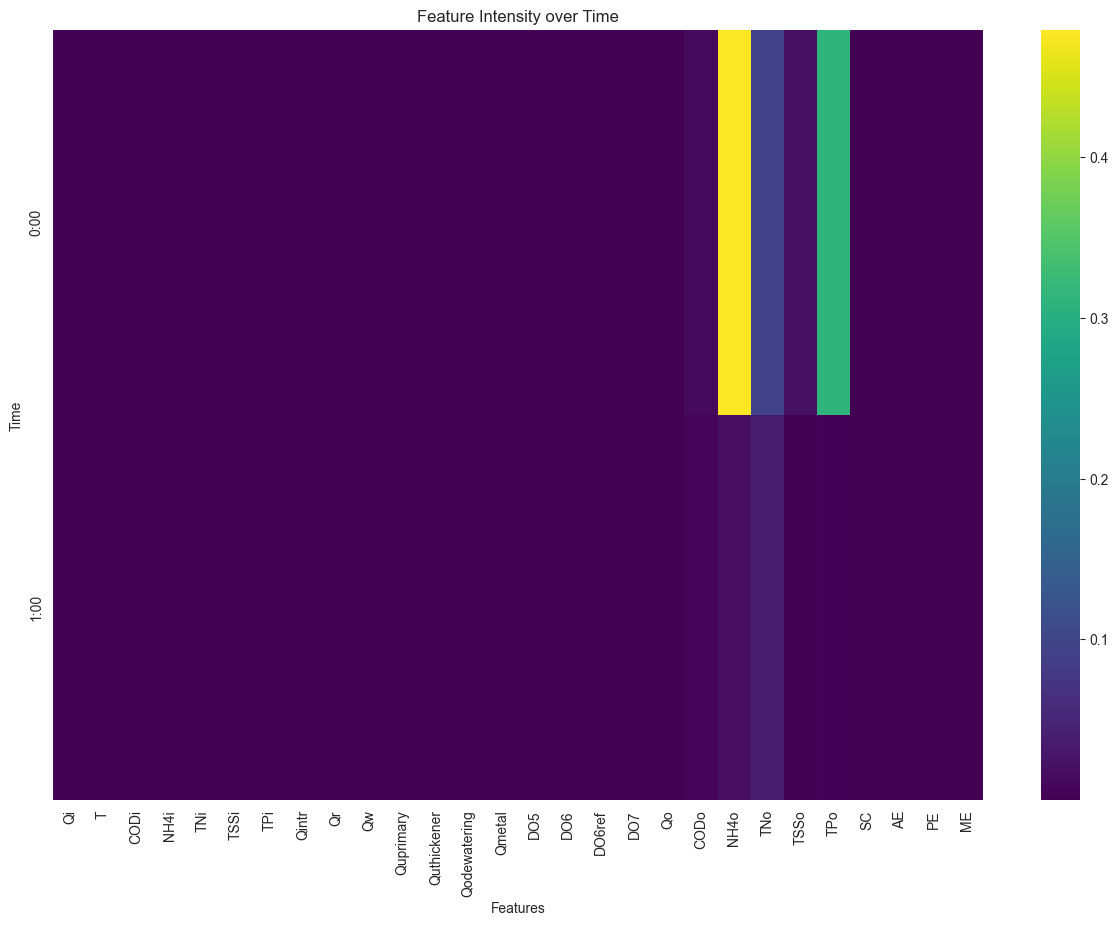

test r2: 0.9918747504644964 for kk: 1, var: oci


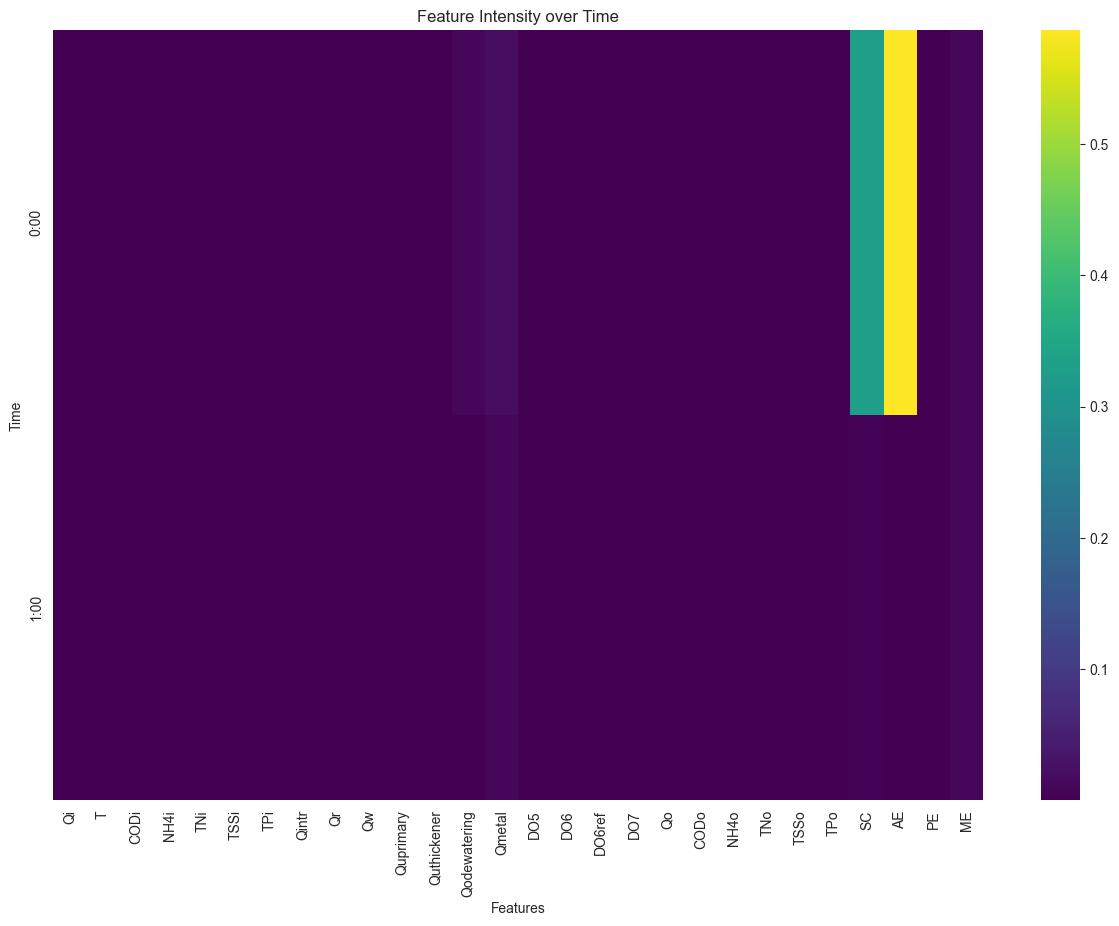

2
test r2: 0.9900451498212737 for kk: 2, var: eqi


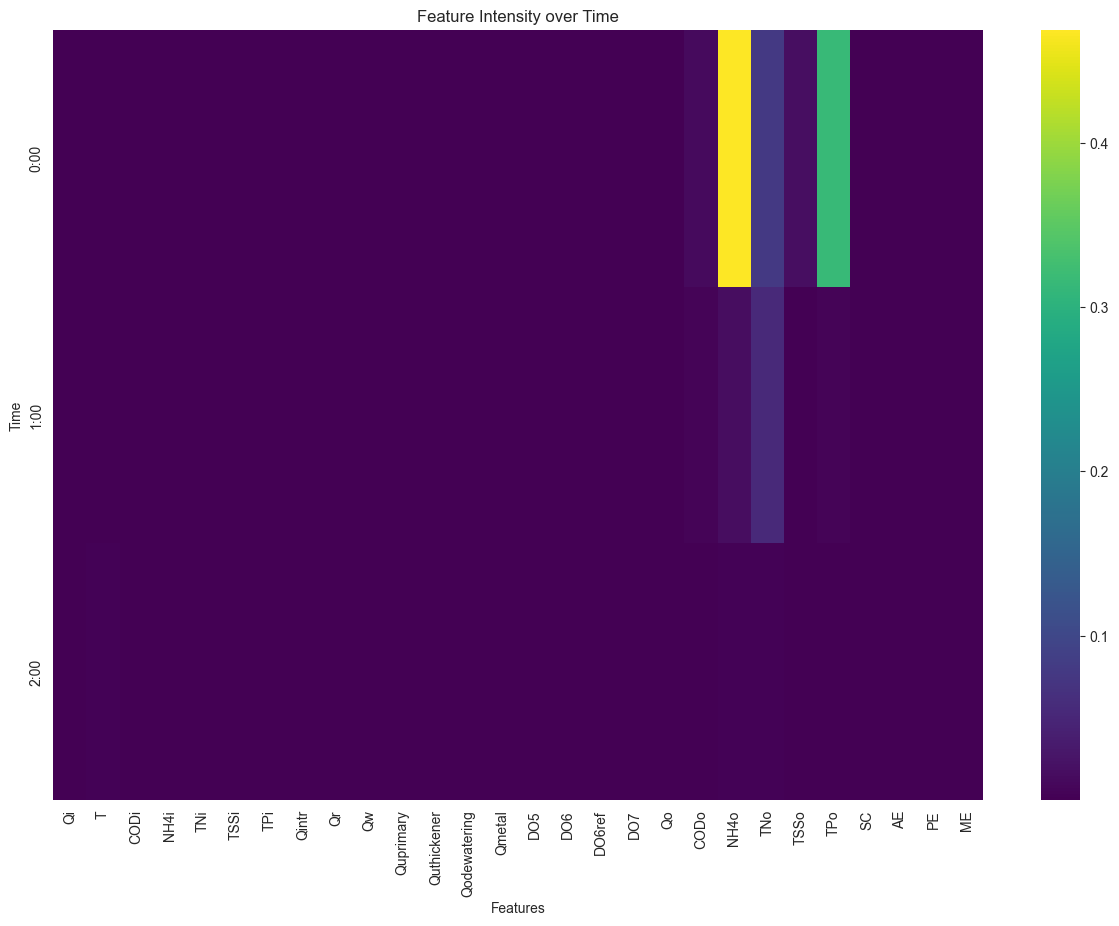

test r2: 0.9906791686651958 for kk: 2, var: oci


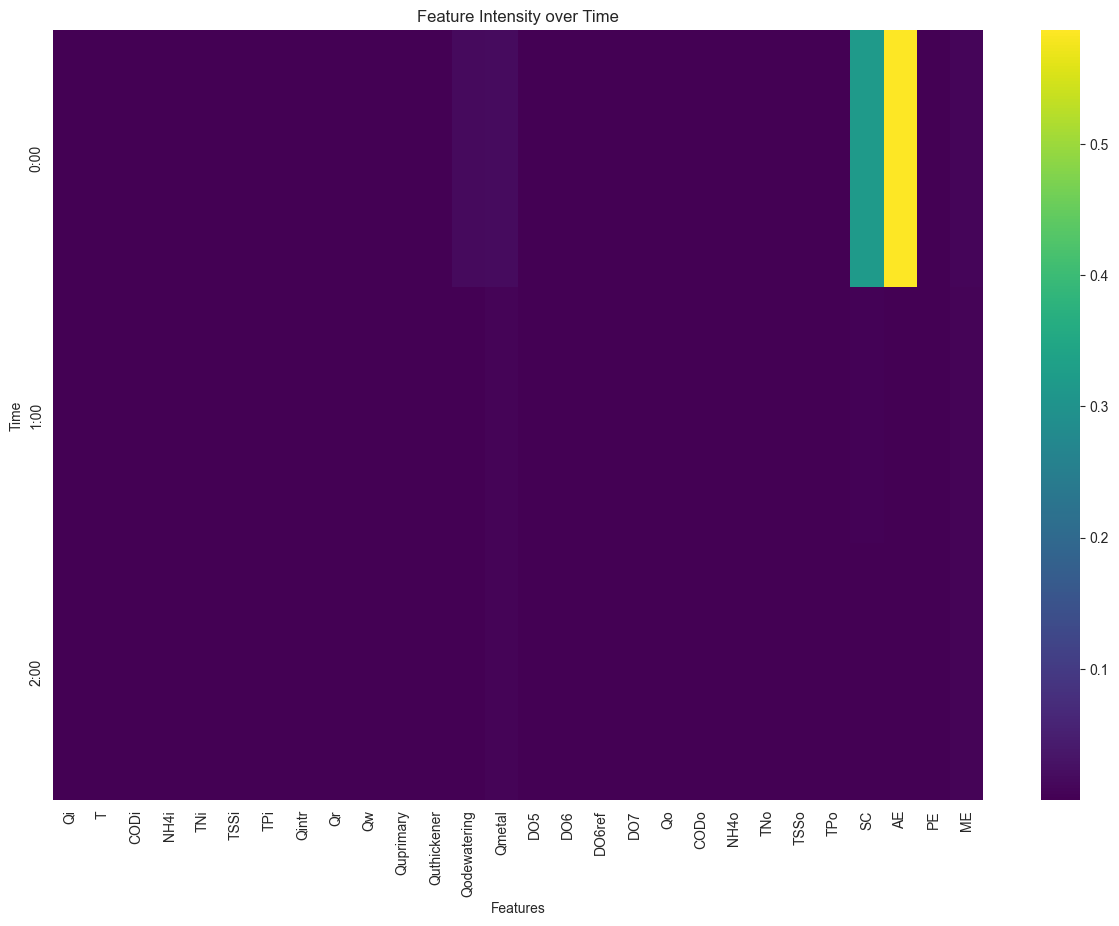

3
test r2: 0.9910859993823915 for kk: 3, var: eqi


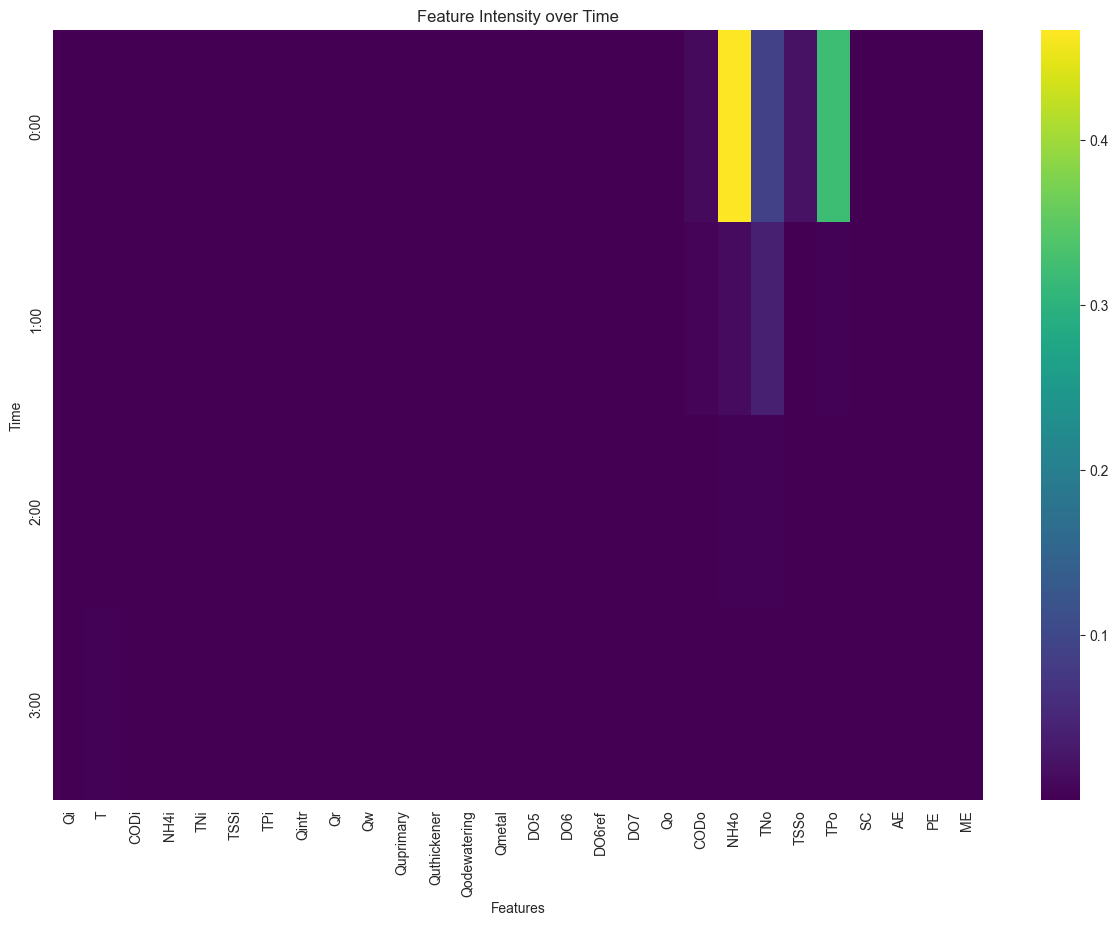

test r2: 0.9903082803804257 for kk: 3, var: oci


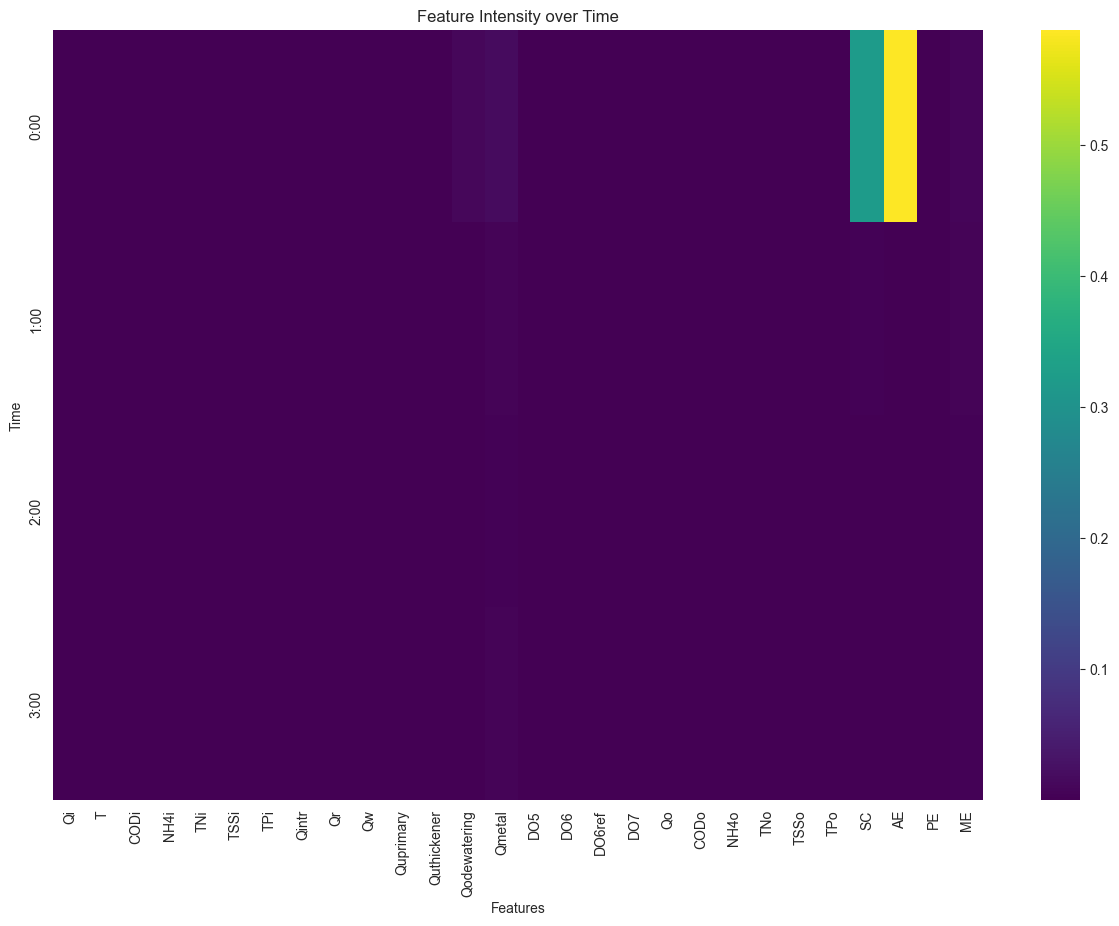

4
test r2: 0.9889514873642635 for kk: 4, var: eqi


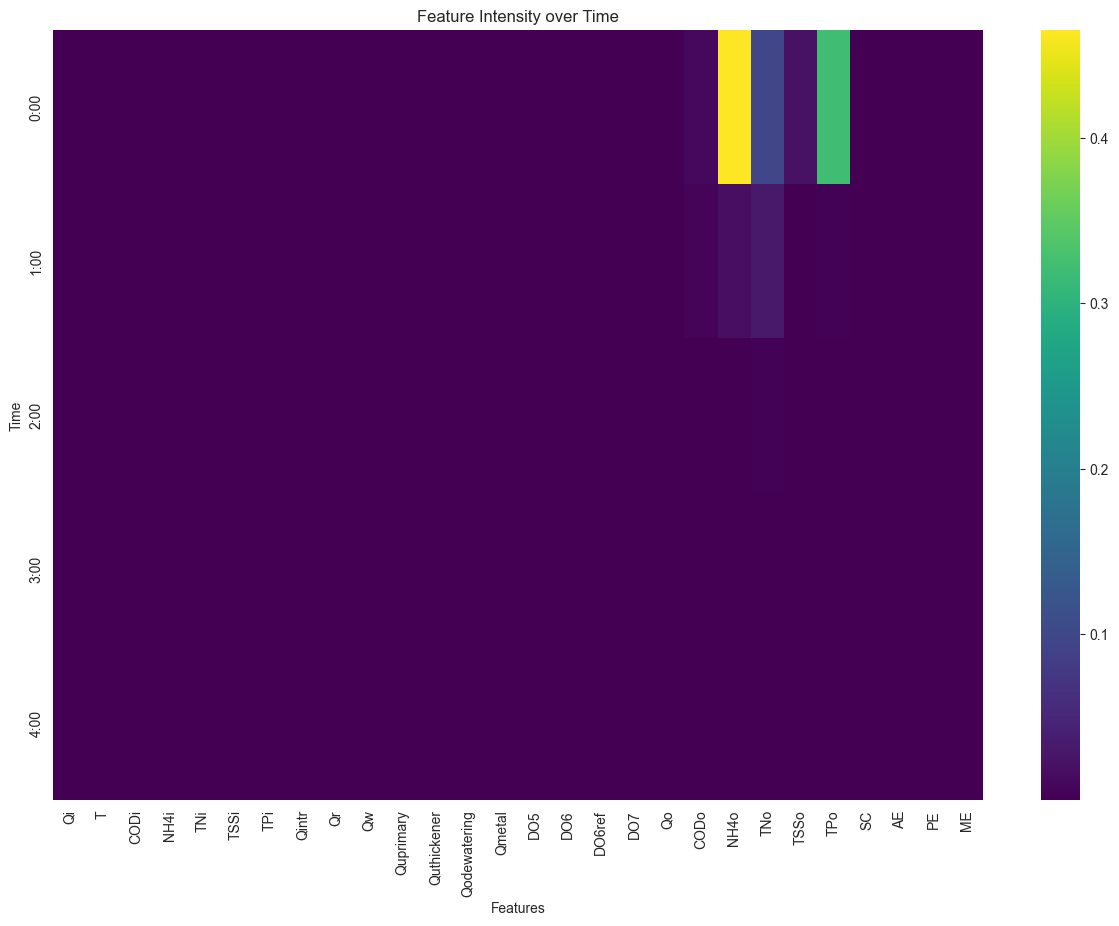

test r2: 0.9902361247868066 for kk: 4, var: oci


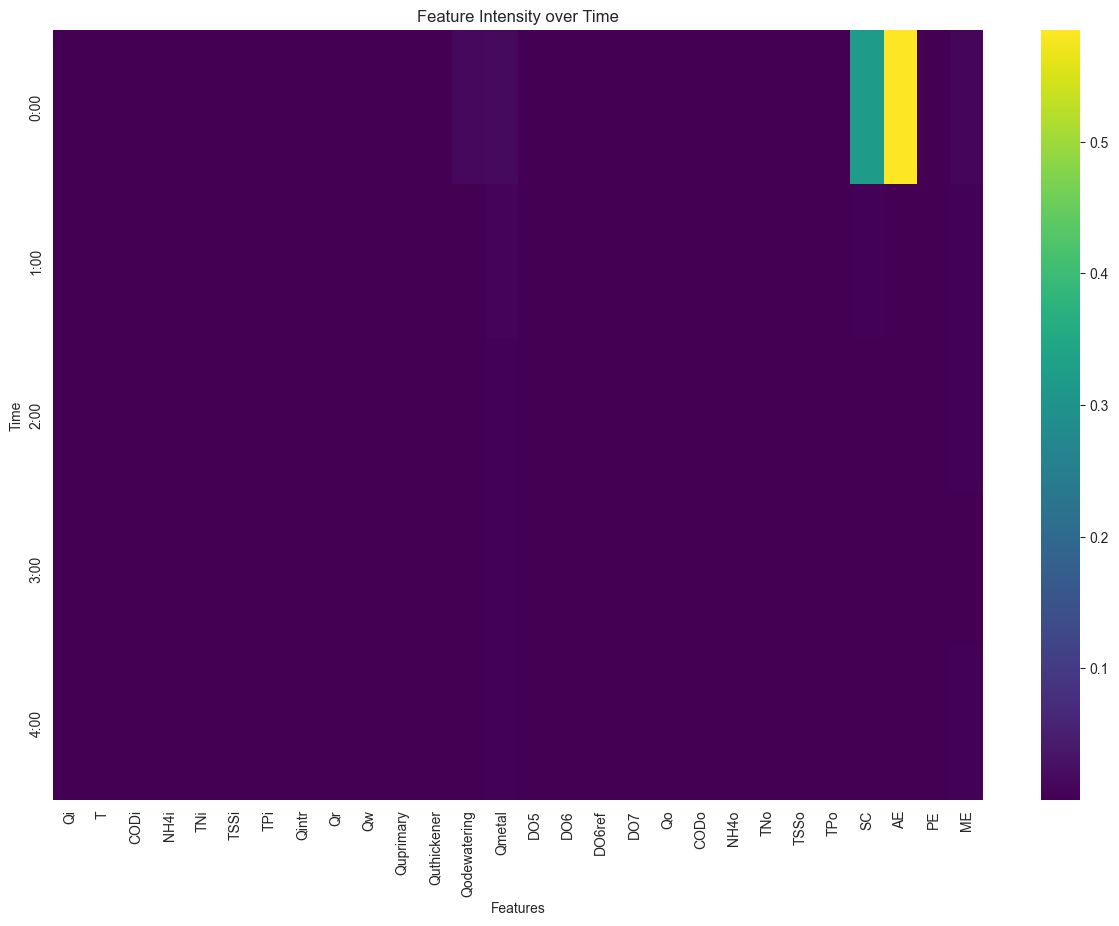

5
test r2: 0.9913871442595985 for kk: 5, var: eqi


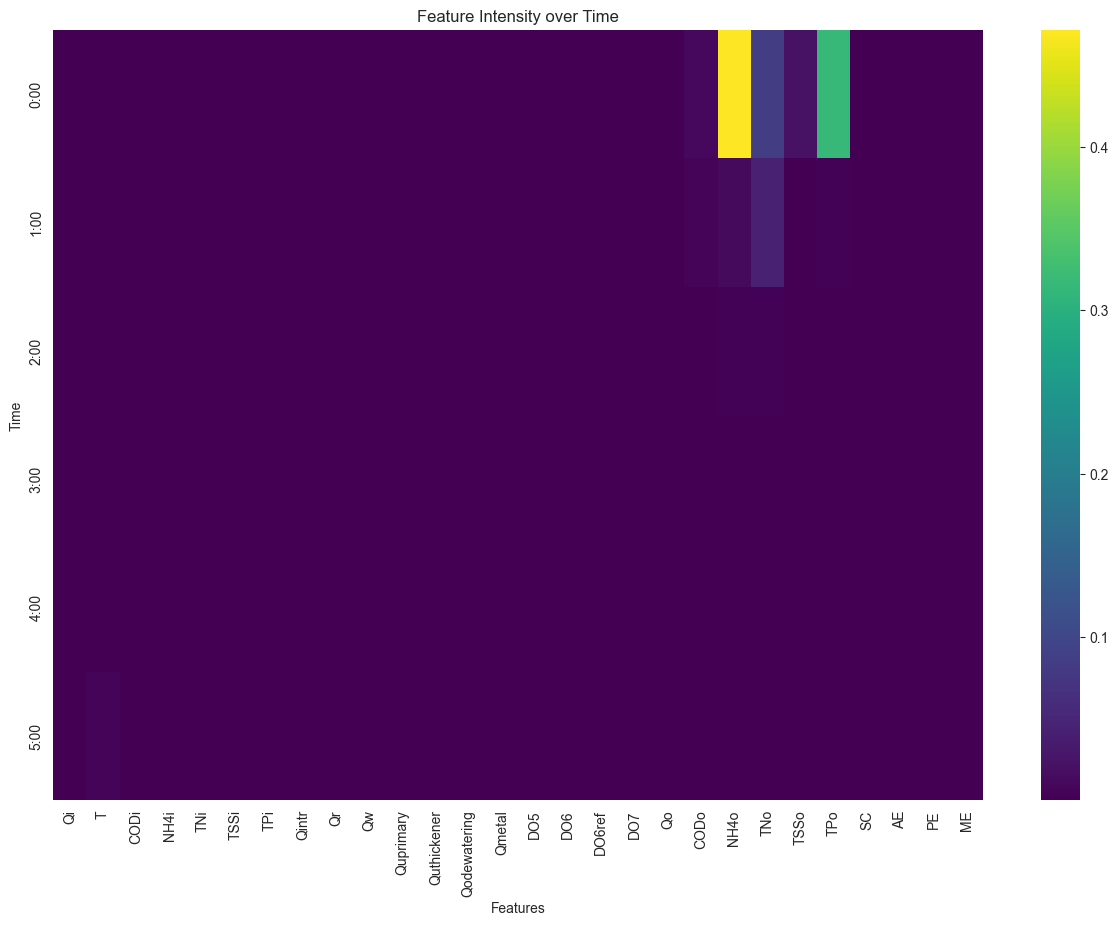

test r2: 0.9900686888991027 for kk: 5, var: oci


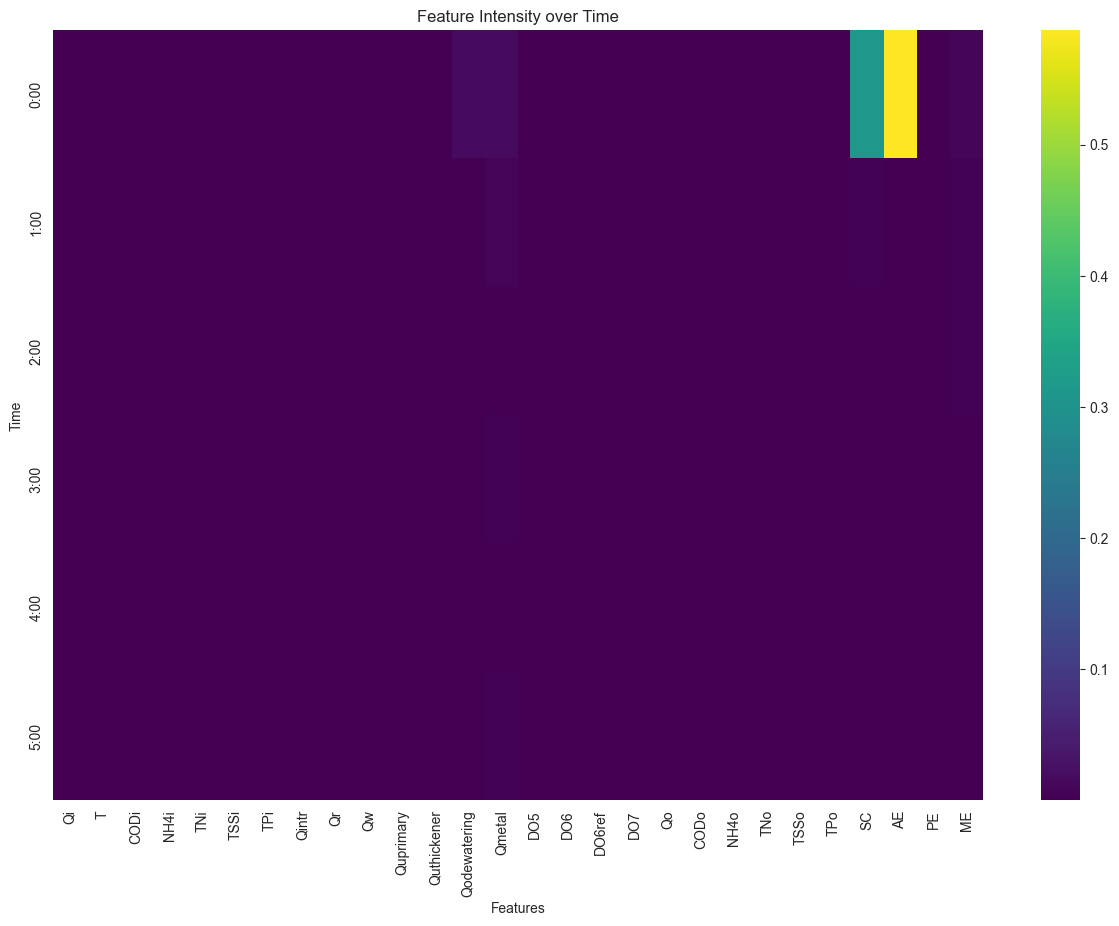

6
test r2: 0.9898964309972869 for kk: 6, var: eqi


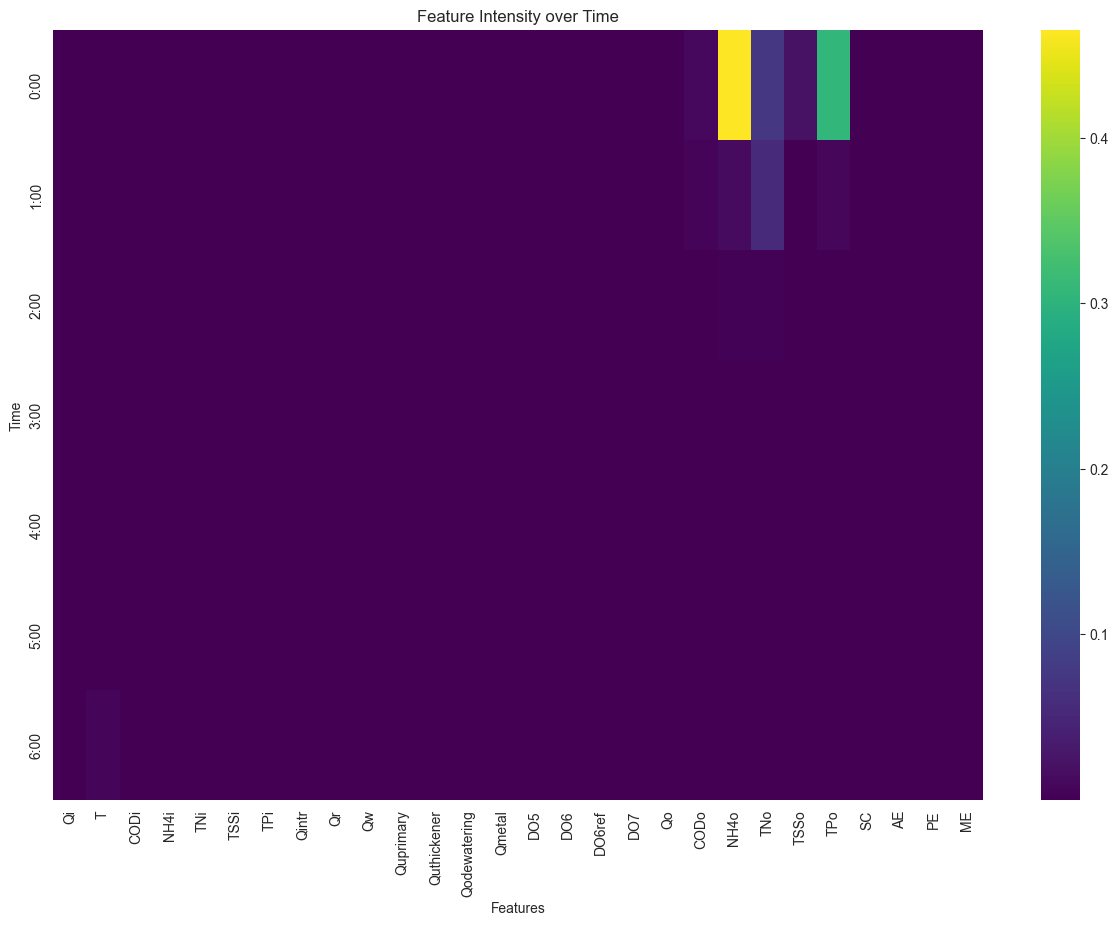

test r2: 0.9906532204786604 for kk: 6, var: oci


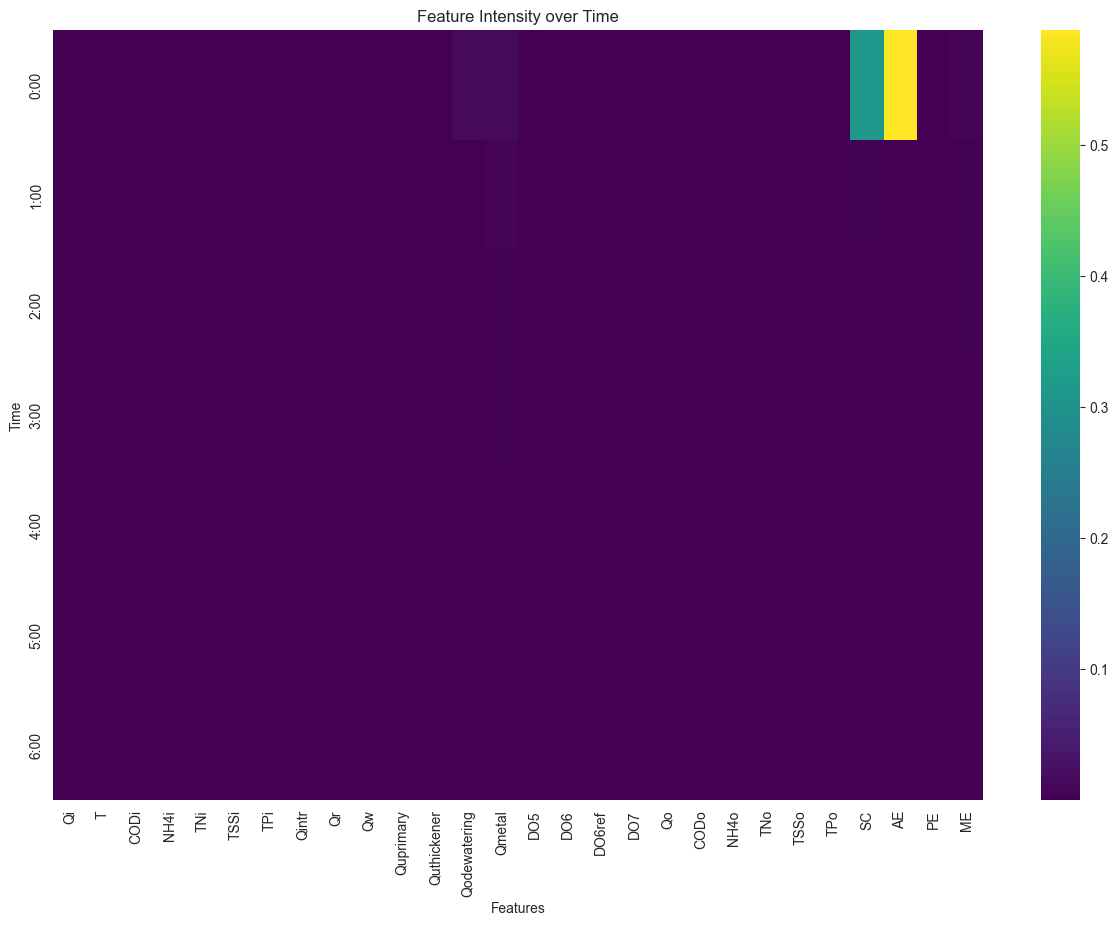

7
test r2: 0.9886992376193199 for kk: 7, var: eqi


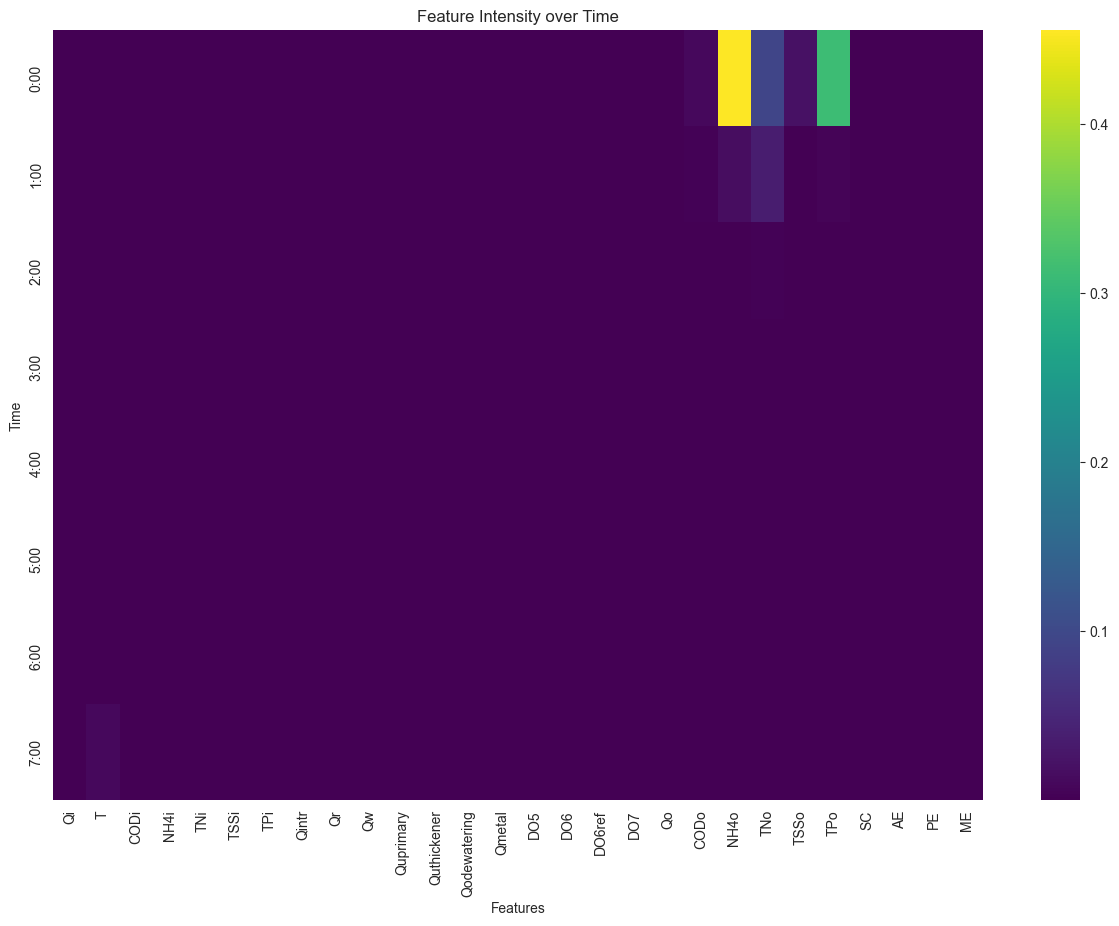

test r2: 0.99042774883684 for kk: 7, var: oci


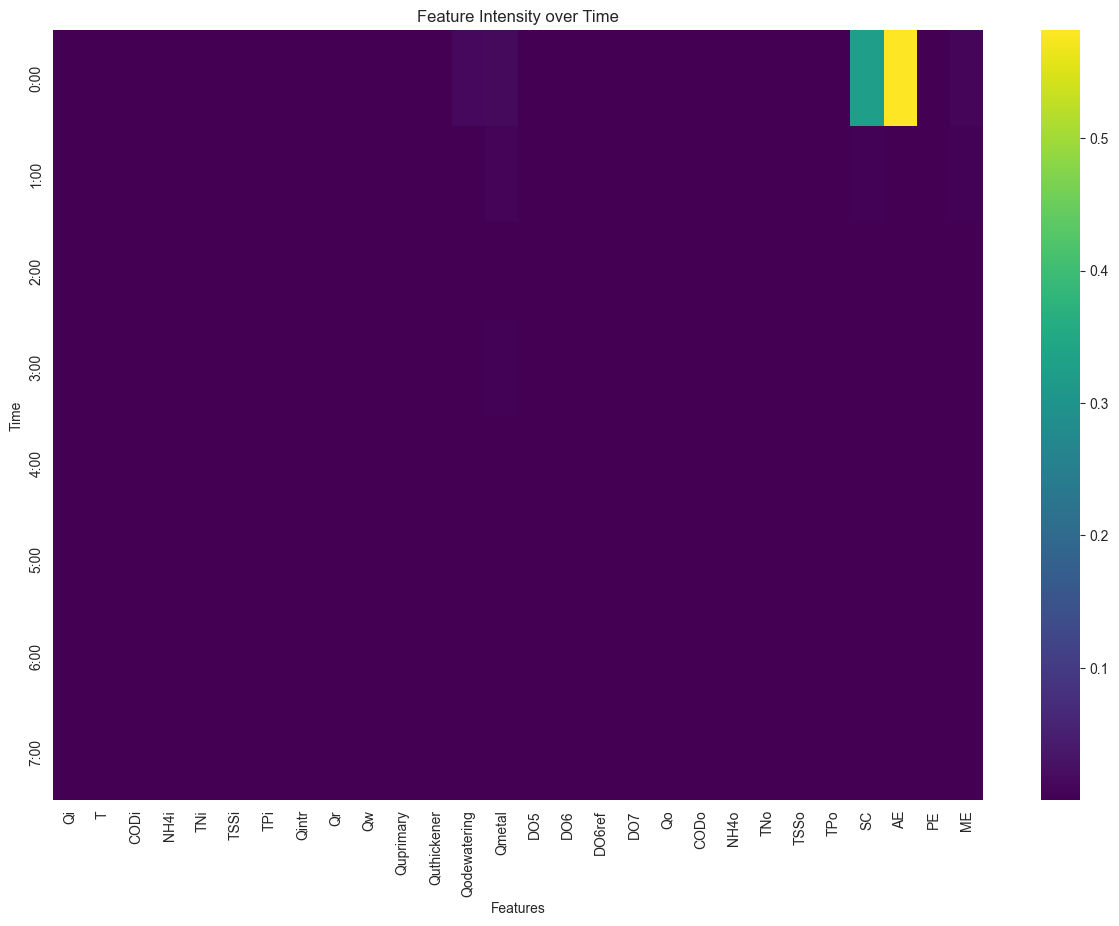

8
test r2: 0.9911697515655358 for kk: 8, var: eqi


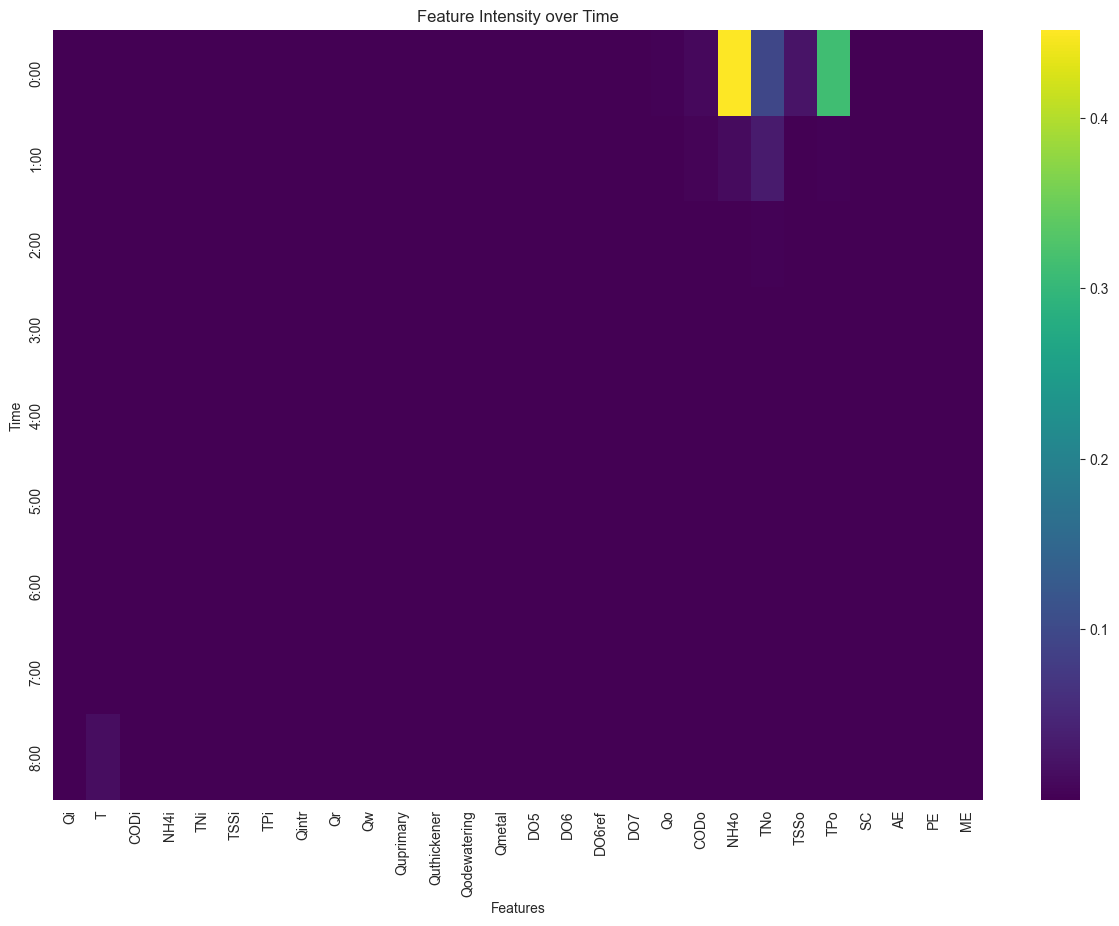

test r2: 0.9900672901761464 for kk: 8, var: oci


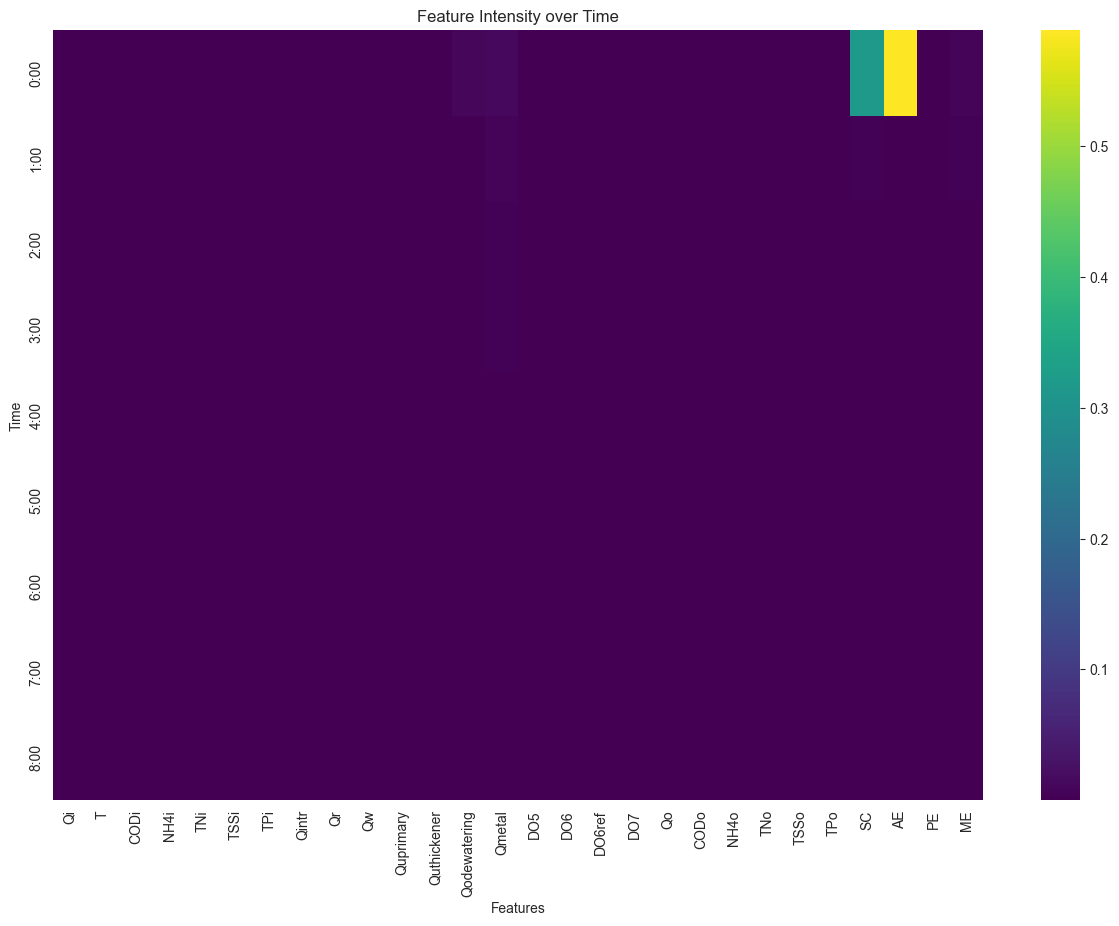

9
test r2: 0.9892497903130004 for kk: 9, var: eqi


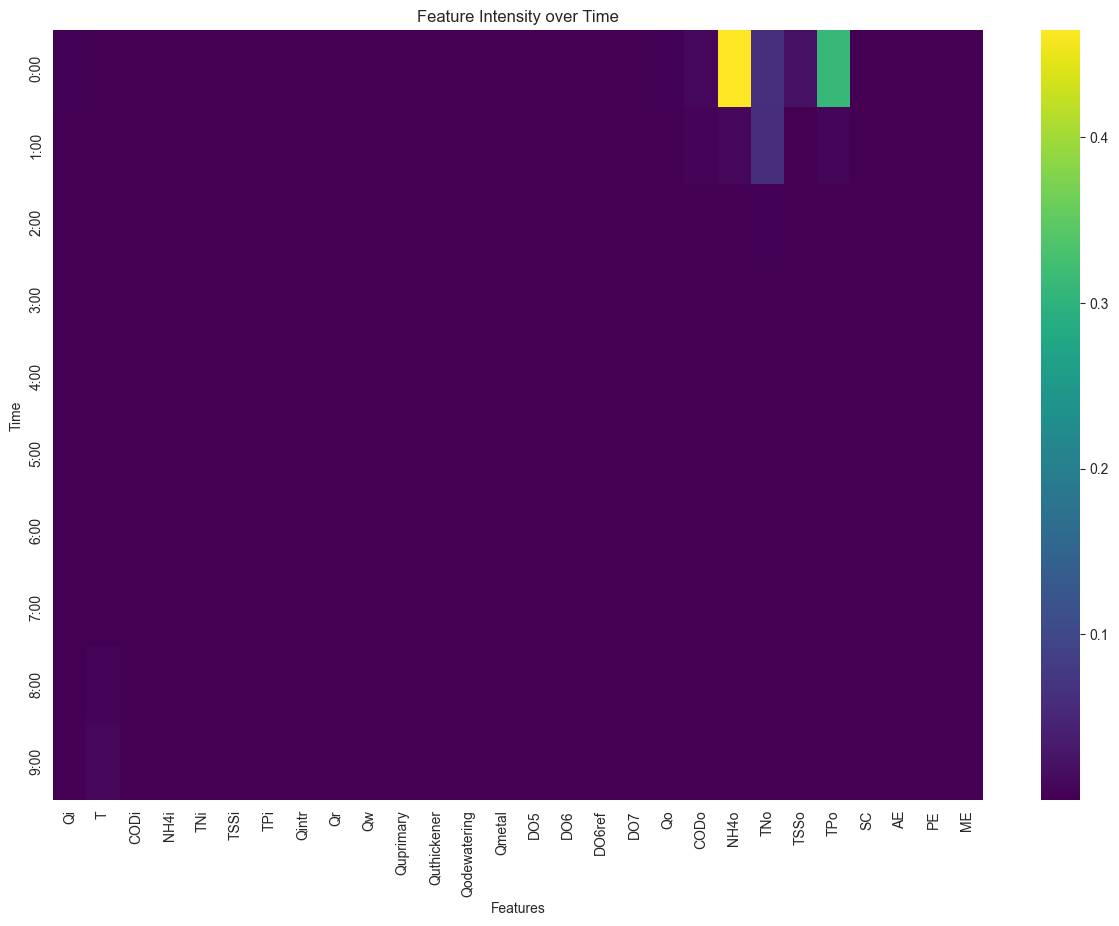

test r2: 0.990423199813623 for kk: 9, var: oci


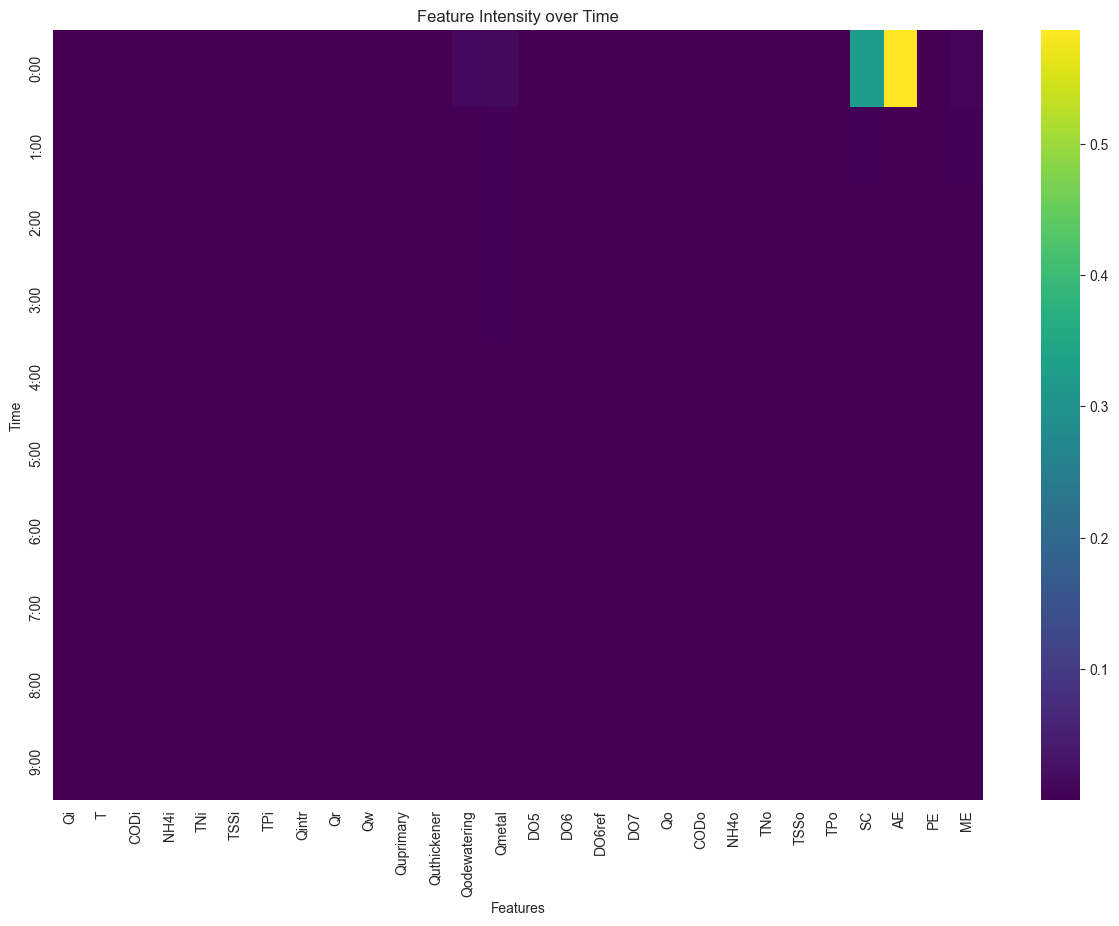

10
test r2: 0.9889847791390947 for kk: 10, var: eqi


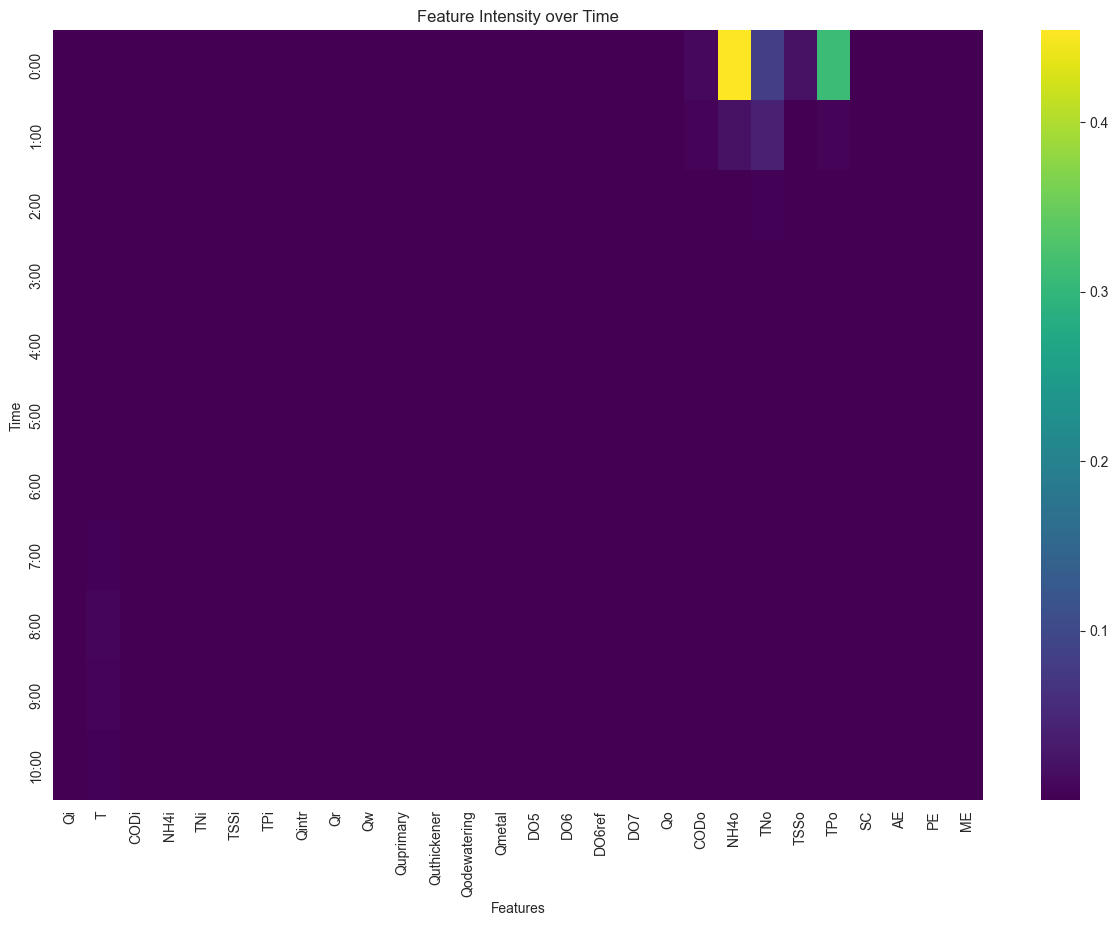

test r2: 0.9898043780431471 for kk: 10, var: oci


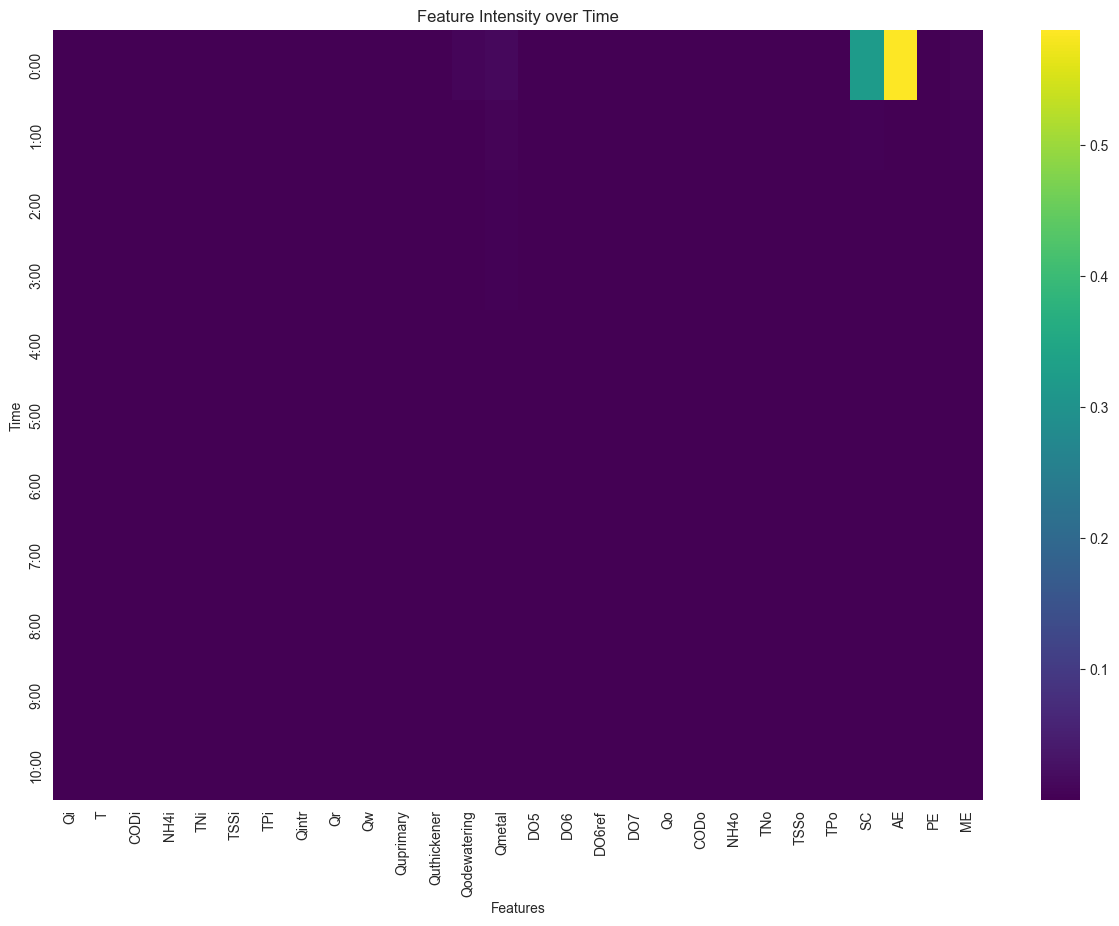

11
test r2: 0.9889845026660682 for kk: 11, var: eqi


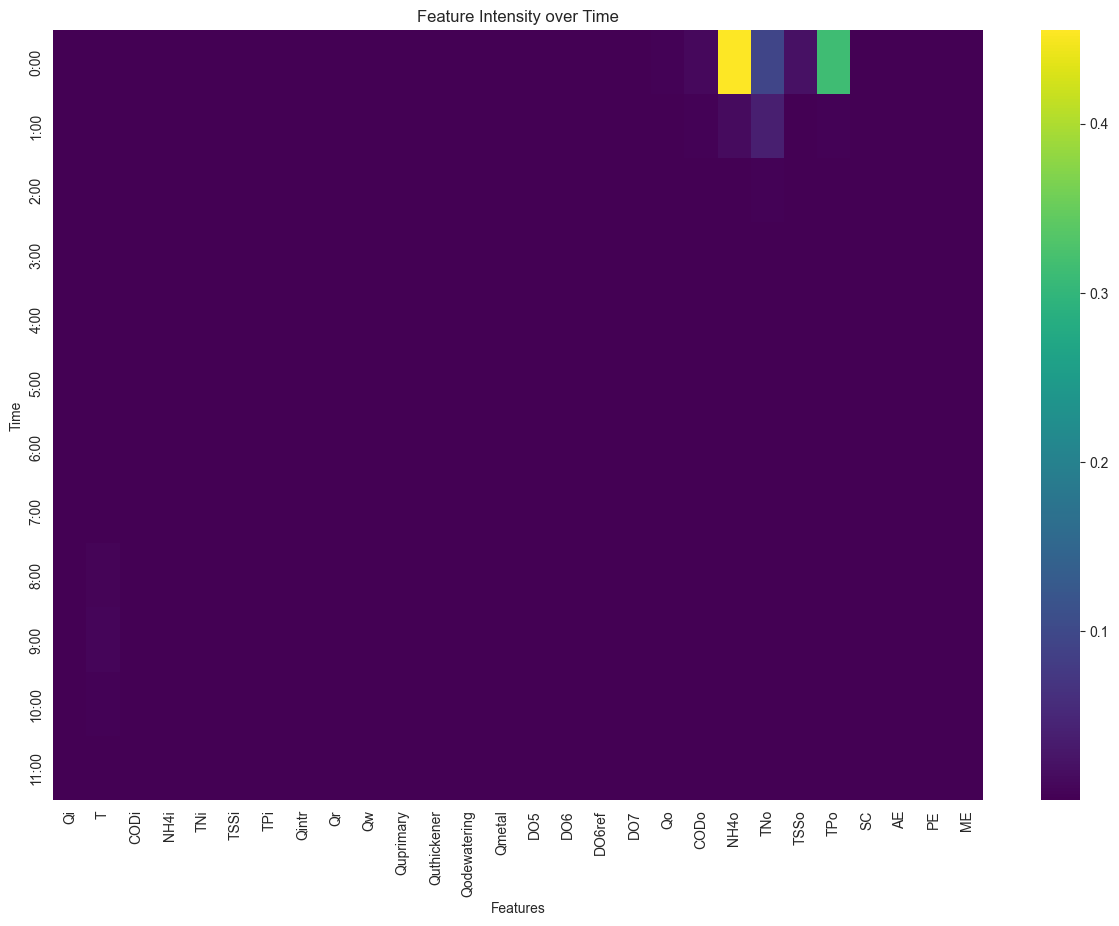

test r2: 0.9896059085962535 for kk: 11, var: oci


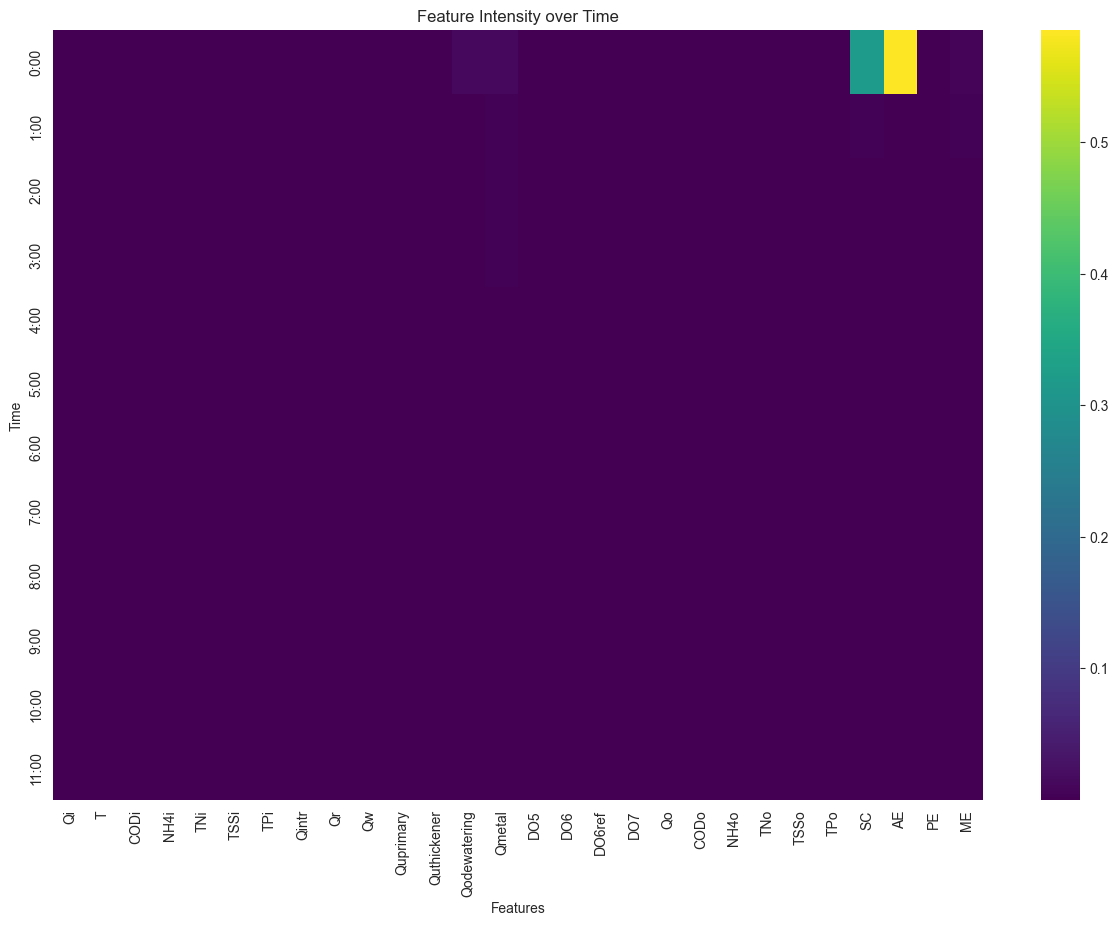

12
test r2: 0.9864156442584452 for kk: 12, var: eqi


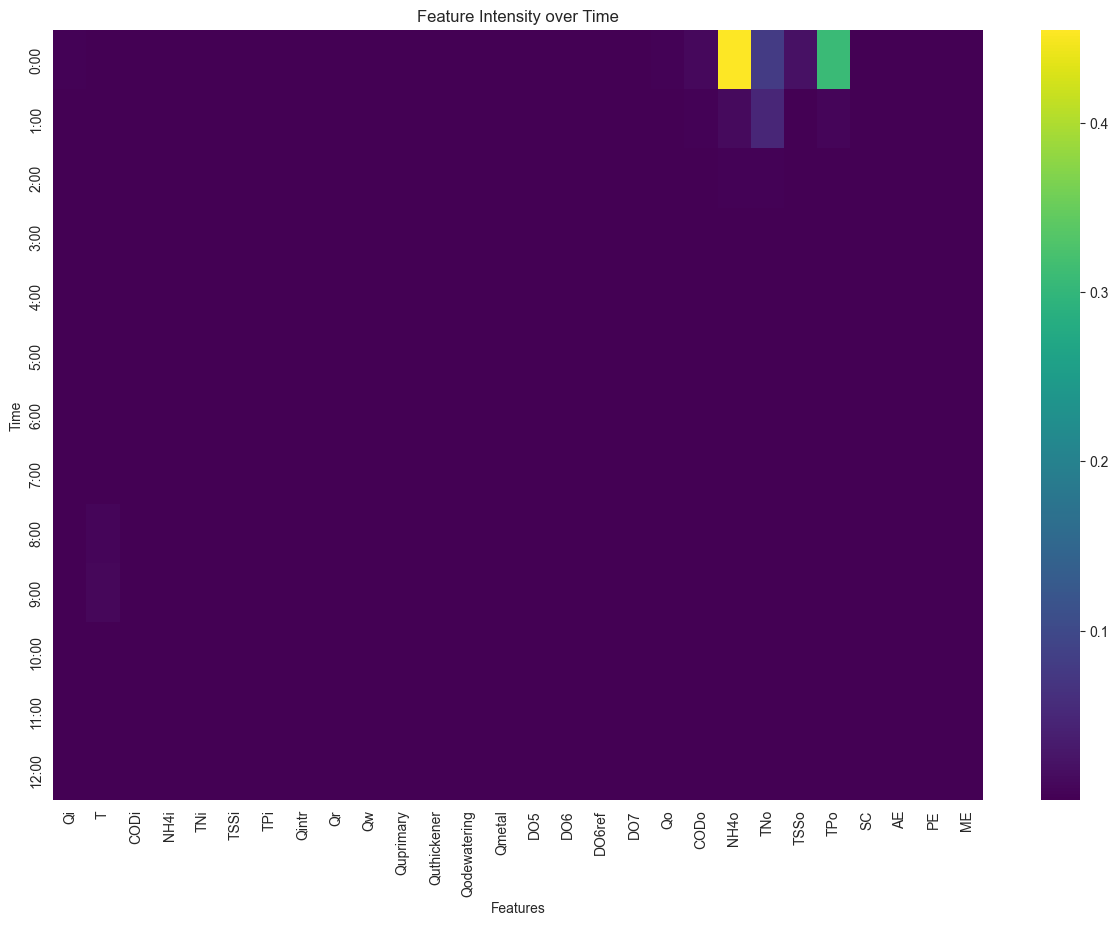

test r2: 0.9898283659815706 for kk: 12, var: oci


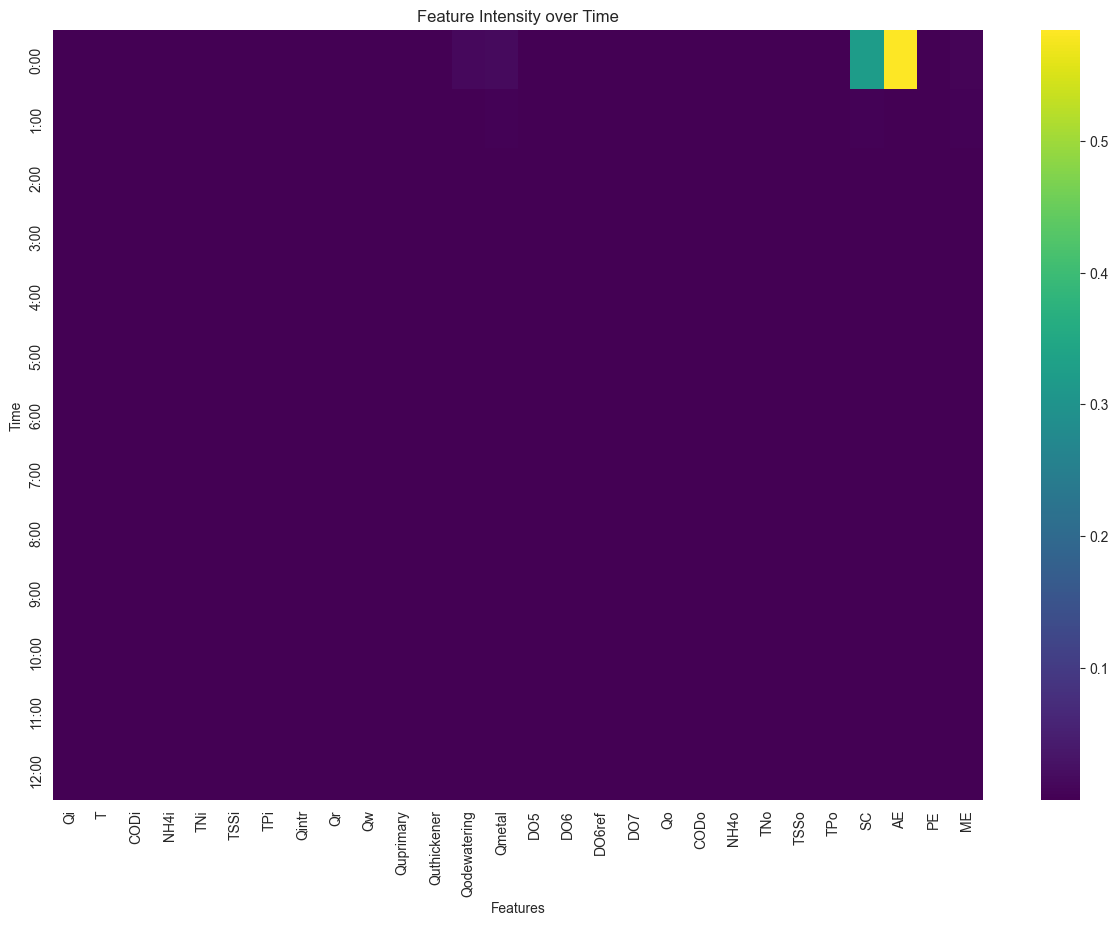

13
test r2: 0.9880409719859762 for kk: 13, var: eqi


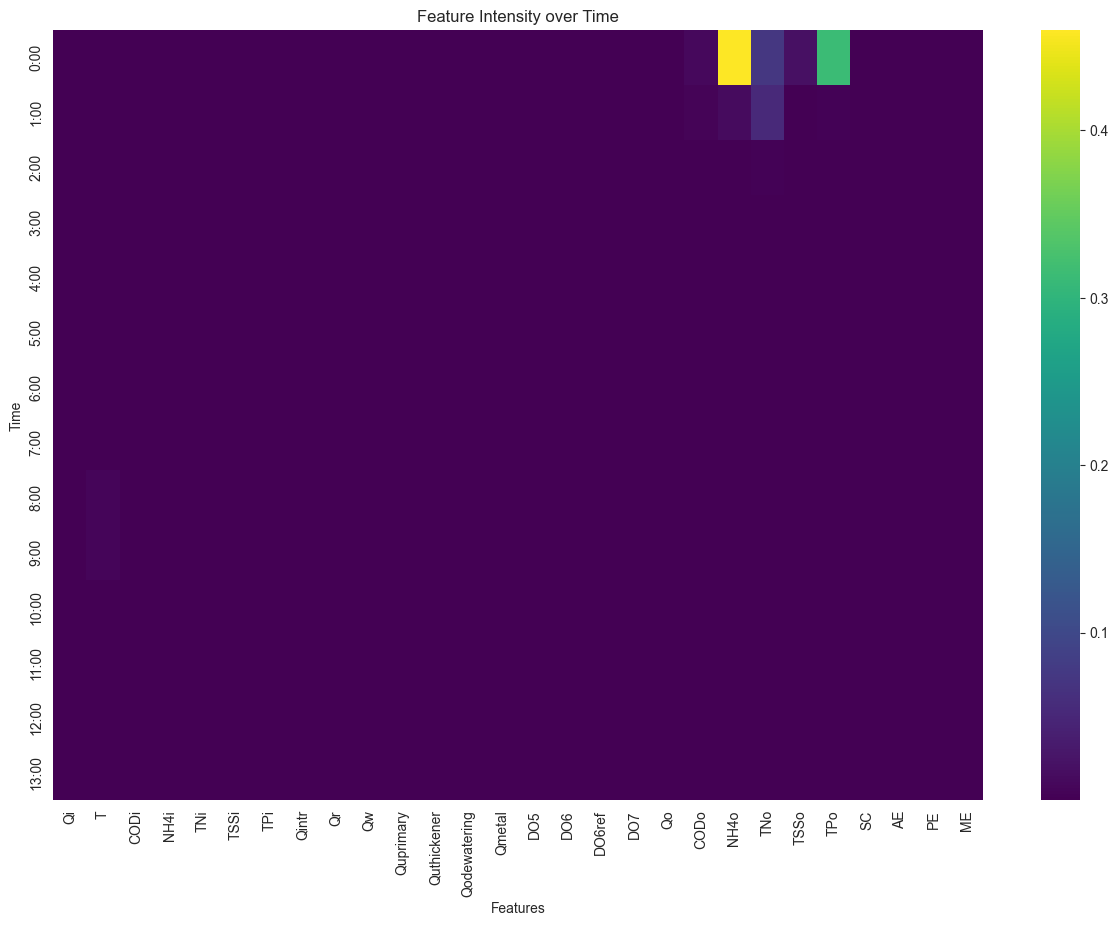

test r2: 0.9892820967765215 for kk: 13, var: oci


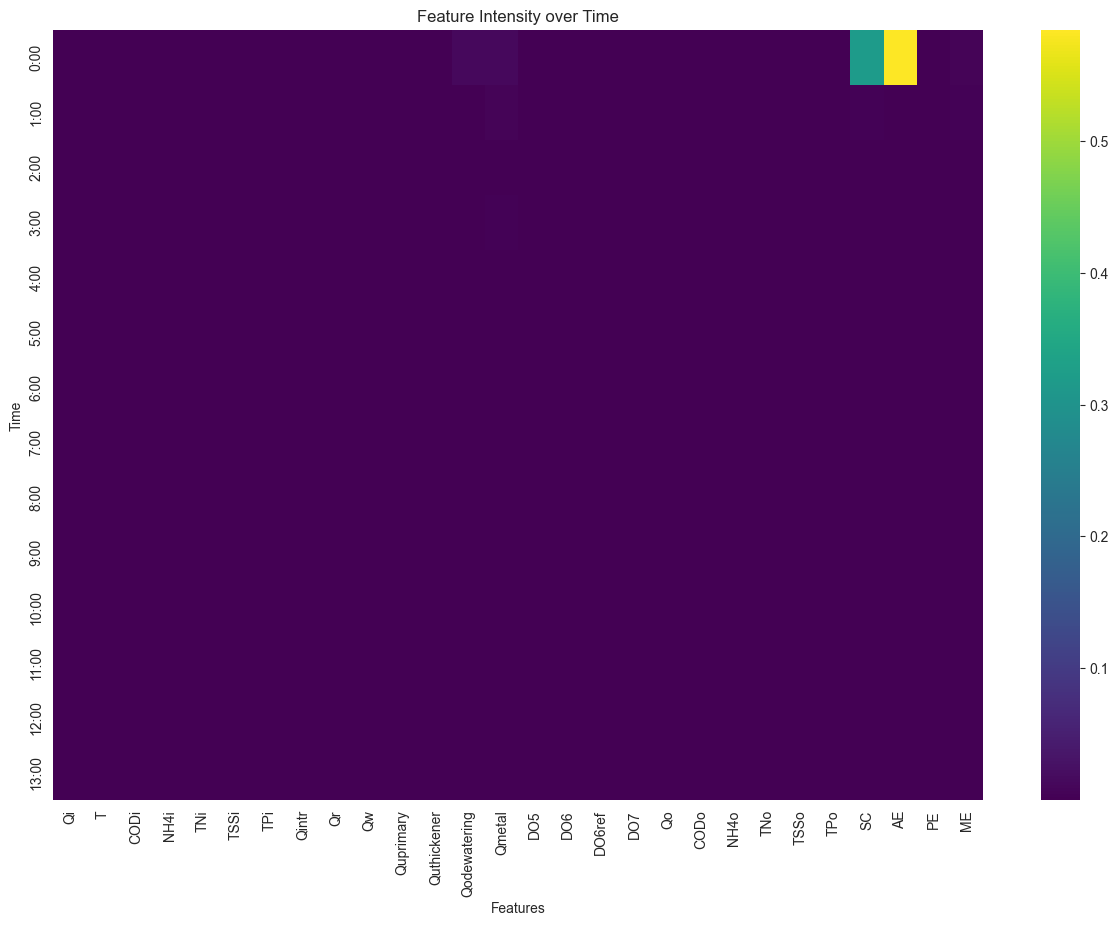

14
test r2: 0.9886221193566522 for kk: 14, var: eqi


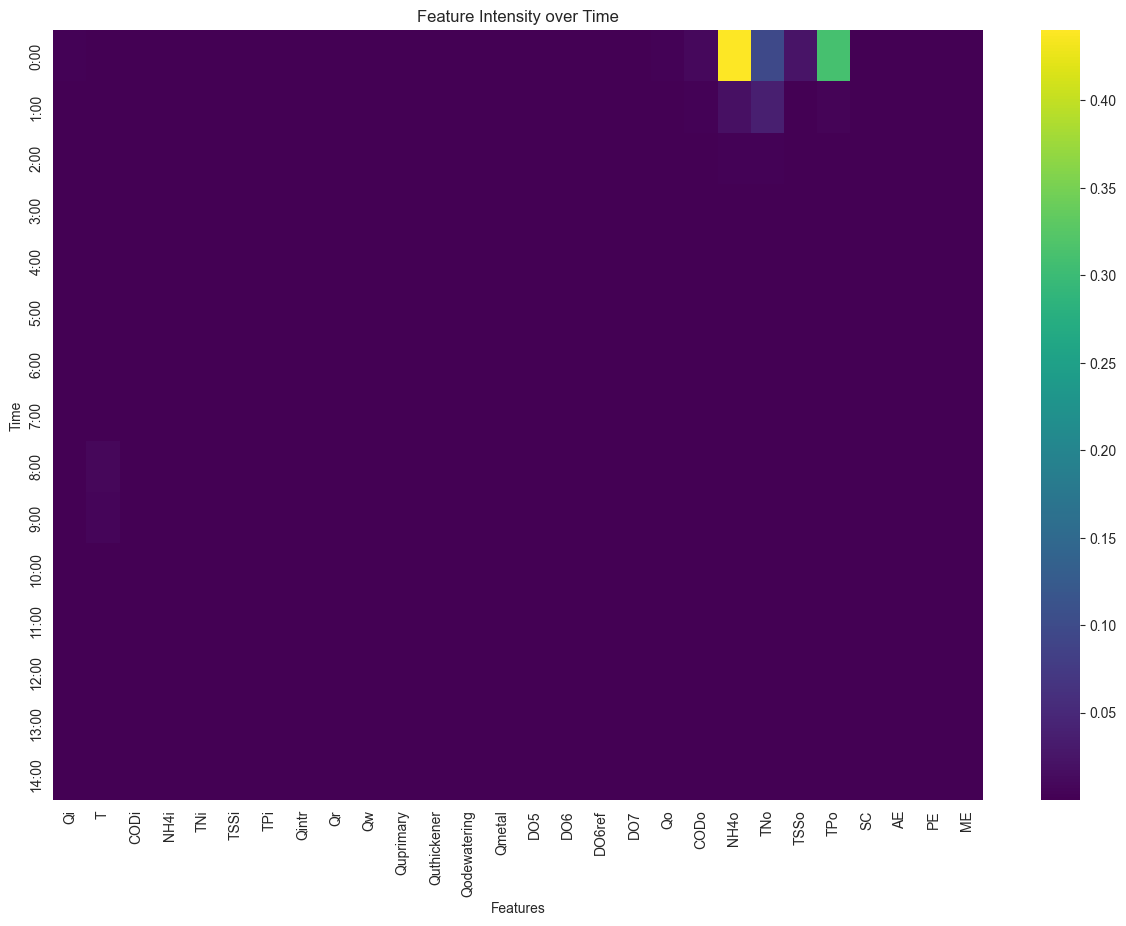

test r2: 0.9883869086381649 for kk: 14, var: oci


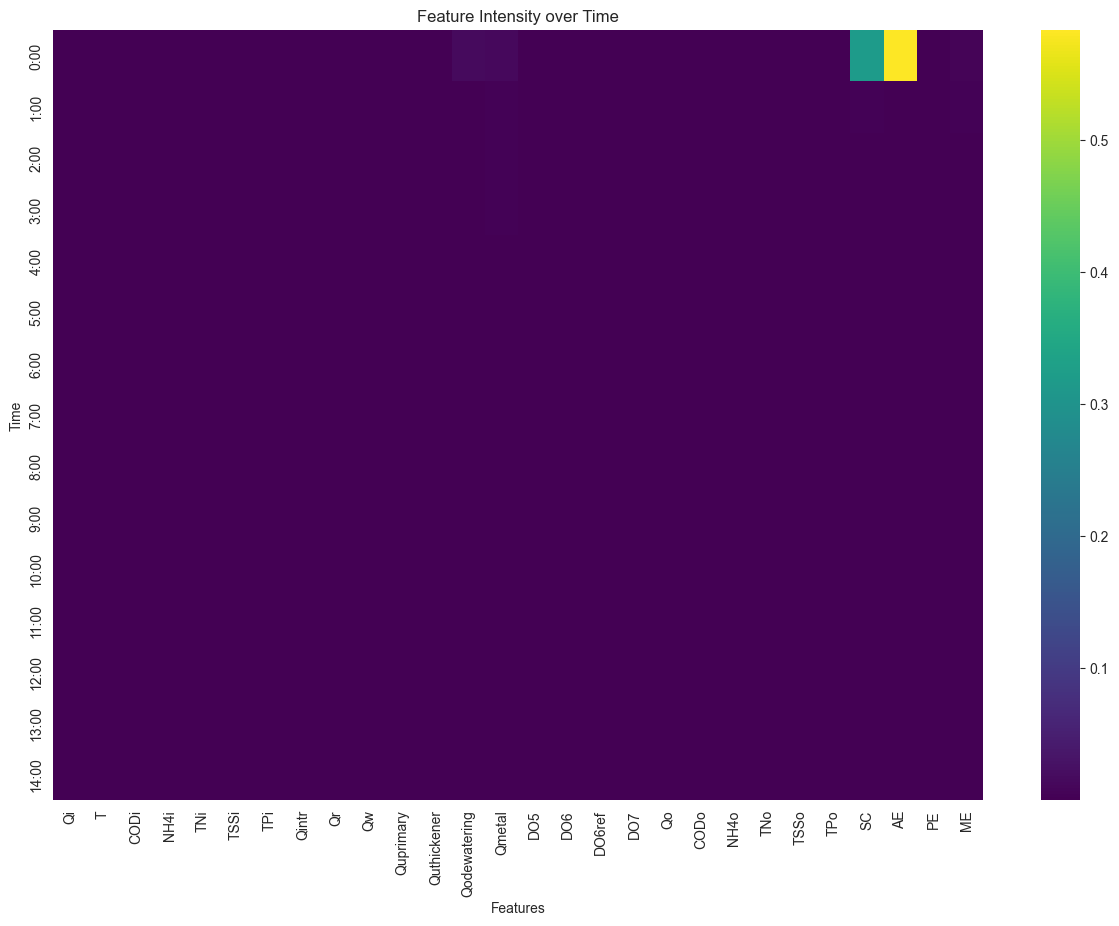

15
test r2: 0.98513722661914 for kk: 15, var: eqi


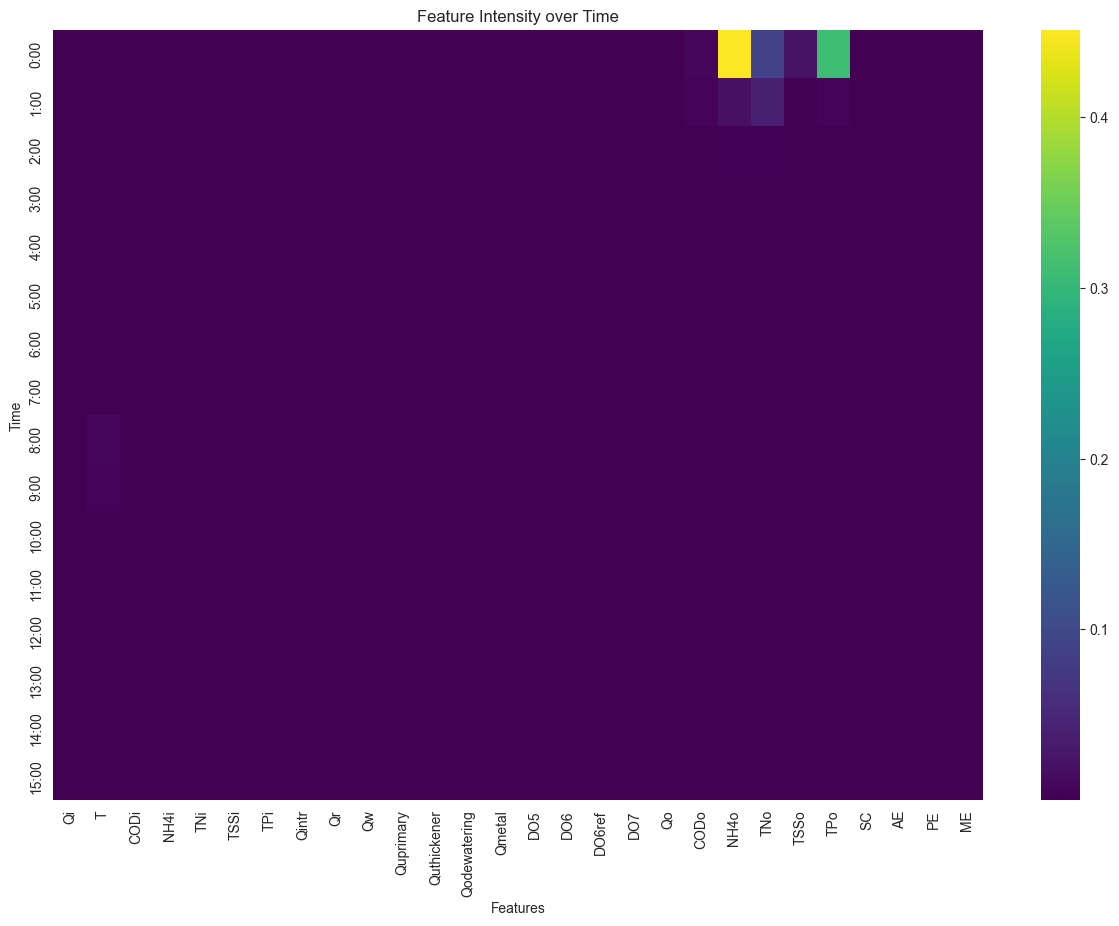

test r2: 0.9892769011243714 for kk: 15, var: oci


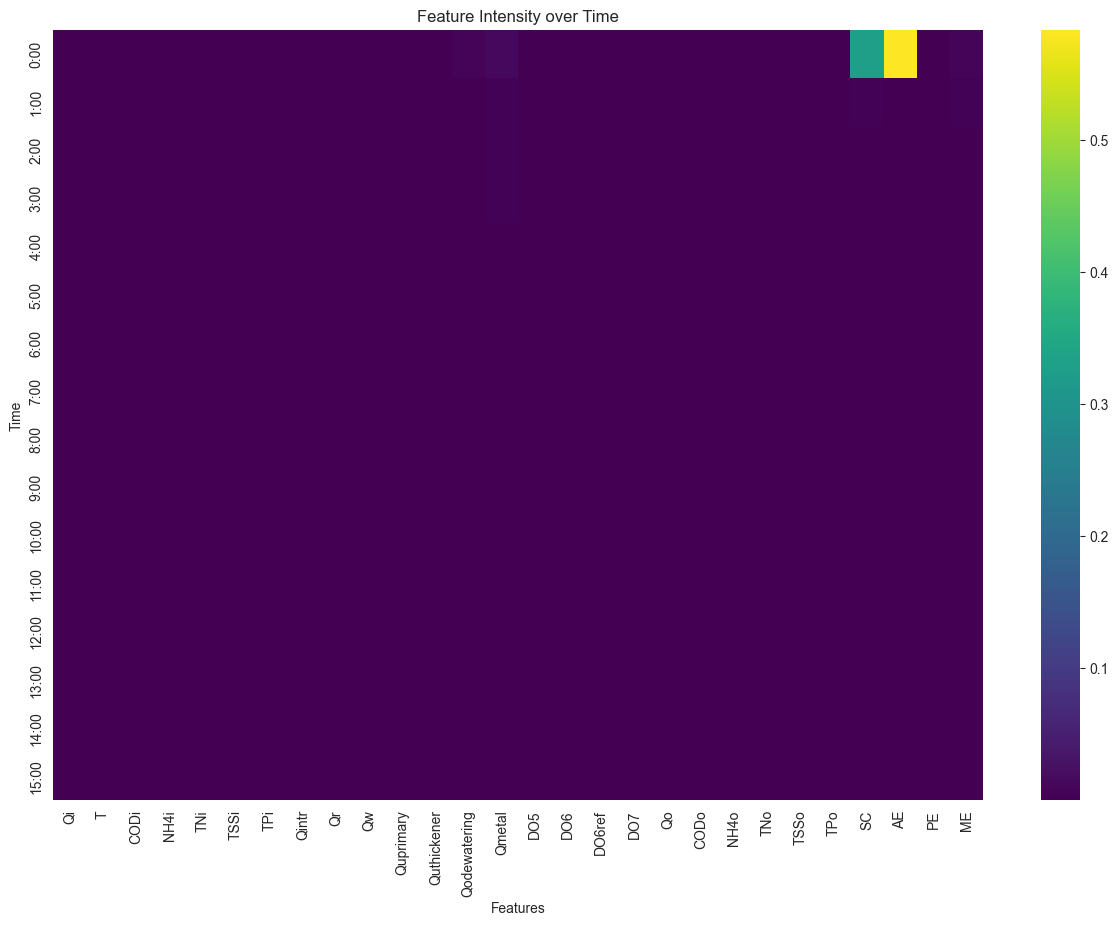

In [71]:
# eqi
n_features = 28


for kk in list_hours_shifted:
    print(kk)       
    # print results to file
    fname_prefix = 'data/df_delay_'
    fname_postfix = '_hours_result_sim2.pkl'
    
    # create the file name and input data
    file_name = fname_prefix + kk + fname_postfix
    df_delay_16_hours_result=pd.read_pickle(file_name)

    # create the output variables
    y_EQI = df_delay_16_hours_result['EQI']
    y_OCI = df_delay_16_hours_result['OCI']
    ys = [(y_EQI, 'eqi'), (y_OCI, 'oci')]

   
    list_names_new = []
    kk_int=int(kk)
    # remove the columns that are not used in the input data file
    for ii in range(0,len(list_col_drop)):
        for jj in range(1,kk_int+1):
            list_names_new.append(list_col_drop[ii]+str(jj))

    X = df_delay_16_hours_result.drop(columns=list_names_new)
    X = X.drop(columns=['EQI', 'OCI'])

    for y_, var in ys:
        X_train, X_test, y_train, y_test = train_test_split(X, y_, test_size=0.1, shuffle=True)

        model = RandomForestRegressor(n_estimators=100, bootstrap=True, random_state=42, oob_score=True)
        model = model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        test_accuracy, test_mae, test_mse, test_rmse, test_mape, test_r2 = evaluate(model, X_test, y_test)
        print(f"test r2: {test_r2} for kk: {kk}, var: {var}")

        importances = model.feature_importances_

        np.random.seed(0)
        data = importances.reshape(int(kk)+1, 28)

        # Create time and feature labels for the axes
        time_labels = [f"{i}:00" for i in range(data.shape[0])]
        feature_labels = [f"{feature}" for feature in X_train.columns[:n_features]]

        # Create the heatmap
        plt.figure(figsize=(15, 10))
        sns.heatmap(data, annot=False, fmt=".2f", xticklabels=feature_labels, yticklabels=time_labels, cmap="viridis")

        # Adding titles and labels
        plt.title("Feature Intensity over Time")
        plt.xlabel("Features")
        plt.ylabel("Time")

        # Show the plot
        plt.show()

In [ ]:
features = ["Qi", "CODi", "NH4i", "TNi", "TSSi", "TPi", "Qo", "CODo", "NH4o", "TNo", "TSSo", "TPo"] # features to keep

In [ ]:
# eqi
delays = []
train_acc = []
test_acc = []
testsizes = []
best_grids = []
train_maes = []
train_mses = []
train_rmses = []
train_mapes = []
test_maes = []
test_mses = []
test_rmses = []
test_mapes = []

columns_to_drop = set(df_hourly.columns) - set(features)
columns_to_drop = list(columns_to_drop)


# no delay df_hourly
print("no delay")
X = df_hourly.drop(columns=columns_to_drop)
y_ = df_hourly['EQI']

test_s = 0.3
delays.append(0)
testsizes.append(test_s)
X_train, X_test, y_train, y_test = train_test_split(X, y_, test_size=test_s, shuffle=False)

rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, scoring='neg_mean_absolute_error', return_train_score=True)
grid_search.fit(X_train, y_train)

best_grid = grid_search.best_estimator_
best_grids.append(best_grid)
train_accuracy, train_mae, train_mse, train_rmse, train_mape = evaluate(best_grid, X_train, y_train)
train_acc.append(train_accuracy)
train_maes.append(train_mae)
train_mses.append(train_mse)
train_rmses.append(train_rmse)
train_mapes.append(train_mape)


test_accuracy, test_mae, test_mse, test_rmse, test_mape = evaluate(best_grid, X_test, y_test)
test_acc.append(test_accuracy)
test_maes.append(test_mae)
test_mses.append(test_mse)
test_rmses.append(test_rmse)
test_mapes.append(test_mape)
    
plot_results(grid_search, param='n_estimators')


for kk in list_hours_shifted:
    print(kk)
    fname_prefix = 'data/df_delay_'
    fname_postfix = '_hours_result_sim2.pkl'

    # create the file name and input data
    file_name = fname_prefix + kk + fname_postfix
    df_delay_16_hours_result=pd.read_pickle(file_name)

    list_names_new = []
    kk_int=int(kk)
    # remove the columns that are not used in the input data file
    for ii in range(0,len(columns_to_drop)):
        for jj in range(0,kk_int+1):
            if jj==0:
                list_names_new.append(columns_to_drop[ii])
            else:
                list_names_new.append(columns_to_drop[ii]+str(jj))
    
    y_ = df_delay_16_hours_result[f'EQI{kk}']
    X = df_delay_16_hours_result.drop(columns=list_names_new)
    
    # check different test sizes
    test_s = 0.3
    delays.append(kk)
    testsizes.append(test_s)
    X_train, X_test, y_train, y_test = train_test_split(X, y_, test_size=test_s, shuffle=False)

    rf = RandomForestRegressor(random_state=42)
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, scoring='neg_mean_absolute_error', return_train_score=True)
    grid_search.fit(X_train, y_train)

    best_grid = grid_search.best_estimator_
    best_grids.append(best_grid)
    train_accuracy, train_mae, train_mse, train_rmse, train_mape = evaluate(best_grid, X_train, y_train)
    train_acc.append(train_accuracy)
    train_maes.append(train_mae)
    train_mses.append(train_mse)
    train_rmses.append(train_rmse)
    train_mapes.append(train_mape)


    test_accuracy, test_mae, test_mse, test_rmse, test_mape = evaluate(best_grid, X_test, y_test)
    test_acc.append(test_accuracy)
    test_maes.append(test_mae)
    test_mses.append(test_mse)
    test_rmses.append(test_rmse)
    test_mapes.append(test_mape)
    
    plot_results(grid_search, param='n_estimators')
    #plot_results(grid_search, param='max_depth')


df = pd.DataFrame.from_dict({
 'kk': delays,
 'test_size': testsizes,
 'grid': best_grids,
 'train_acc': train_acc,
 'test_acc': test_acc,
 'train_mae': train_maes,
 'test_mae': test_maes,
 'train_mse': train_mses,
 'test_mse': test_mses,
 'train_rmse': train_rmses,
 'test_rmse': test_rmses,
 'train_mape': train_mapes,
 'test_mape': test_mapes
 })

In [ ]:
# eqi
n_features = 12

kk = 0
df_ = df[df['kk'] == kk]
X = df_hourly.drop(columns=columns_to_drop)
y_ = df_hourly['EQI']

X_train, X_test, y_train, y_test = train_test_split(X, y_, test_size=0.3, shuffle=False)

model = df_.iloc[0]['grid']
model = model.fit(X_train, y_train)

y_pred = model.predict(X_test)

importances = model.feature_importances_

np.random.seed(0)
data = importances.reshape(int(kk)+1, n_features)

# Create time and feature labels for the axes
time_labels = [f"{i}:00" for i in range(data.shape[0])]
feature_labels = [f"{feature}" for feature in X_train.columns[:n_features]]

# Create the heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(data, annot=False, fmt=".2f", xticklabels=feature_labels, yticklabels=time_labels, cmap="viridis")

# Adding titles and labels
plt.title("Feature Intensity over Time")
plt.xlabel("Features")
plt.ylabel("Time")

# Show the plot
plt.show()

for kk in list_hours_shifted:
    df_ = df[df['kk'] == kk]
    fname_prefix = 'data/df_delay_'
    fname_postfix = '_hours_result_sim2.pkl'

    # create the file name and input data
    file_name = fname_prefix + kk + fname_postfix
    df_delay_16_hours_result=pd.read_pickle(file_name)

    list_names_new = []
    kk_int=int(kk)
    # remove the columns that are not used in the input data file
    for ii in range(0,len(columns_to_drop)):
        for jj in range(0,kk_int+1):
            if jj==0:
                list_names_new.append(columns_to_drop[ii])
            else:
                list_names_new.append(columns_to_drop[ii]+str(jj))
    
    y_ = df_delay_16_hours_result[f'EQI{kk}']
    X = df_delay_16_hours_result.drop(columns=list_names_new)

    X_train, X_test, y_train, y_test = train_test_split(X, y_, test_size=0.3, shuffle=False)

    model = df_.iloc[0]['grid']
    model = model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    importances = model.feature_importances_
    
    np.random.seed(0)
    data = importances.reshape(int(kk)+1, n_features)

    # Create time and feature labels for the axes
    time_labels = [f"{i}:00" for i in range(data.shape[0])]
    feature_labels = [f"{feature}" for feature in X_train.columns[:n_features]]

    # Create the heatmap
    plt.figure(figsize=(15, 10))
    sns.heatmap(data, annot=False, fmt=".2f", xticklabels=feature_labels, yticklabels=time_labels, cmap="viridis")

    # Adding titles and labels
    plt.title("Feature Intensity over Time")
    plt.xlabel("Features")
    plt.ylabel("Time")

    # Show the plot
    plt.show()

In [ ]:
df

In [ ]:
!pip3 install sklearn_relief

In [ ]:
from sklearn.pipeline import Pipeline
# Feature Selection
import sklearn_relief as sr

In [ ]:
# eqi
delays = []
train_acc = []
test_acc = []
testsizes = []
best_grids = []
train_maes = []
train_mses = []
train_rmses = []
train_mapes = []
test_maes = []
test_mses = []
test_rmses = []
test_mapes = []


param_grid = {
    'rf__max_depth': [2, 5, 9, 10, 12],
    'rf__max_features': ["sqrt", 1, 2, 3],
    'rf__min_samples_leaf': [0.2, 0.4],
    'rf__min_samples_split': [0.2, 0.4],
    'rf__n_estimators': [5, 10, 20, 30, 40, 50]
}


# no delay df_hourly
print("no delay")
X = df_hourly.drop(columns=['EQI', 'OCI'])
y_ = df_hourly['EQI']
test_s = 0.3
delays.append(0)
testsizes.append(test_s)
X_train, X_test, y_train, y_test = train_test_split(X, y_, test_size=test_s, shuffle=False)

fs = sr.RReliefF(n_features=5)
rf = RandomForestRegressor(random_state=42)
relief = Pipeline([('rrelieff', fs), ('rf', rf)])

grid_search = GridSearchCV(estimator=relief, param_grid=param_grid, cv=3, n_jobs=-1, scoring='r2', return_train_score=True)
grid_search.fit(X_train, y_train)

best_grid = grid_search.best_estimator_
best_grids.append(best_grid)



exit()
train_accuracy, train_mae, train_mse, train_rmse, train_mape = evaluate(best_grid, X_train, y_train)
train_acc.append(train_accuracy)
train_maes.append(train_mae)
train_mses.append(train_mse)
train_rmses.append(train_rmse)
train_mapes.append(train_mape)


test_accuracy, test_mae, test_mse, test_rmse, test_mape = evaluate(best_grid, X_test, y_test)
test_acc.append(test_accuracy)
test_maes.append(test_mae)
test_mses.append(test_mse)
test_rmses.append(test_rmse)
test_mapes.append(test_mape)
    
plot_results(grid_search, param='n_estimators')


for kk in list_hours_shifted:
    print(kk)
    fname_prefix = 'data/df_delay_'
    fname_postfix = '_hours_result_sim2.pkl'

    # create the file name and input data
    file_name = fname_prefix + kk + fname_postfix
    df_delay_16_hours_result=pd.read_pickle(file_name)

    list_col_drop = ['EQI', 'OCI']
    list_names_new = []
    kk_int=int(kk)
    # remove the columns that are not used in the input data file
    for ii in range(0,len(list_col_drop)):
        for jj in range(1,kk_int+1):
            list_names_new.append(list_col_drop[ii]+str(jj))

    X = df_delay_16_hours_result.drop(columns=list_names_new)
    X = X.drop(columns=['EQI', 'OCI'])
    y_ = df_delay_16_hours_result['EQI']
    
    # check different test sizes
    test_s = 0.3
    delays.append(kk)
    testsizes.append(test_s)
    X_train, X_test, y_train, y_test = train_test_split(X, y_, test_size=test_s, shuffle=False)

    rf = RandomForestRegressor(random_state=42)
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, scoring='r2', return_train_score=True)
    grid_search.fit(X_train, y_train)

    best_grid = grid_search.best_estimator_
    best_grids.append(best_grid)
    train_accuracy, train_mae, train_mse, train_rmse, train_mape = evaluate(best_grid, X_train, y_train)
    train_acc.append(train_accuracy)
    train_maes.append(train_mae)
    train_mses.append(train_mse)
    train_rmses.append(train_rmse)
    train_mapes.append(train_mape)


    test_accuracy, test_mae, test_mse, test_rmse, test_mape = evaluate(best_grid, X_test, y_test)
    test_acc.append(test_accuracy)
    test_maes.append(test_mae)
    test_mses.append(test_mse)
    test_rmses.append(test_rmse)
    test_mapes.append(test_mape)
    
    plot_results(grid_search, param='n_estimators')
    #plot_results(grid_search, param='max_depth')


df = pd.DataFrame.from_dict({
 'kk': delays,
 'test_size': testsizes,
 'grid': best_grids,
 'train_acc': train_acc,
 'test_acc': test_acc,
 'train_mae': train_maes,
 'test_mae': test_maes,
 'train_mse': train_mses,
 'test_mse': test_mses,
 'train_rmse': train_rmses,
 'test_rmse': test_rmses,
 'train_mape': train_mapes,
 'test_mape': test_mapes
 })